# Data prepare

## surface

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gcsfs
import zarr
import xarray

# 设置滚动预报的周数
forecast_weeks = 6  # 预测未来6周

# 变量列表及其统计信息
variables = [
    'lsrr',               # Large-scale precipitation rate
    'crr',                # Convective precipitation rate
    'tciw',               # Specific cloud ice
    'tcc',                # Total cloud cover
    'tsrc',               # Top net long-wave radiation flux
    'u10',                # 10m u wind component
    'v10',                # 10m v wind component
    'd2m',                # 2m dewpoint temperature
    't2m',                # 2m temperature
    'surface_latent_heat_flux',  # Surface latent heat flux
    'surface_sensible_heat_flux',  # Surface sensible heat flux
    'sp',                 # Surface pressure
    'swvl',               # Volumetric soil water
    'msl',                # Sea-level pressure
    'siconc',             # Sea ice
    'sst'                 # Sea surface temperature
]

upper_air_vars = [
    'geopotential',
    'vertical_velocity',
    'u_component_of_wind',
    'v_component_of_wind',
    'fraction_of_cloud_cover',
    'temperature',
    'specific_humidity'
]

surface_var_names = [
    'large_scale_rain_rate',
    'convective_rain_rate',
    'total_column_cloud_ice_water',
    'total_cloud_cover',
    'top_net_solar_radiation_clear_sky',
    '10m_u_component_of_wind',
    '10m_v_component_of_wind',
    '2m_dewpoint_temperature',
    '2m_temperature',
    'surface_latent_heat_flux',
    'surface_sensible_heat_flux',
    'surface_pressure',
    'volumetric_soil_water_layer',
    'mean_sea_level_pressure',
    'sea_ice_cover',
    'sea_surface_temperature'
]

# 变量统计信息
ordered_var_stats = {
    'lsrr': {'mean': 1.10E-05, 'std': 2.55E-05},
    'crr': {'mean': 1.29E-05, 'std': 2.97E-05},
    'tciw': {'mean': 0.022627383, 'std': 0.023428712},
    'tcc': {'mean': 0.673692584, 'std': 0.235167906},
    'tsrc': {'mean': 856148, 'std': 534222.125},
    'u10': {'mean': -0.068418466, 'std': 4.427545547},
    'v10': {'mean': 0.197138891, 'std': 3.09530735},
    'd2m': {'mean': 274.2094421, 'std': 20.45770073},
    't2m': {'mean': 278.7841187, 'std': 21.03286934},
    'surface_latent_heat_flux': {'mean': -5410301.5, 'std': 5349063.5},
    'surface_sensible_heat_flux': {'mean': -971651.375, 'std': 2276764.75},
    'sp': {'mean': 96651.14063, 'std': 9569.695313},
    'swvl': {'mean': 0.34216917, 'std': 0.5484813},
    'msl': {'mean': 100972.3438, 'std': 1191.102417},
    'siconc': {'mean': 0.785884917, 'std': 0.914535105},
    'sst': {'mean': 189.7337189, 'std': 136.1803131},
    
    # 高空层变量（按新顺序排列）
    'geopotential': {
        '300': {'mean': 13763.50879, 'std': 1403.990112},
        '500': {'mean': 28954.94531, 'std': 2085.838867},
        '700': {'mean': 54156.85547, 'std': 3300.384277},
        '850': {'mean': 89503.79688, 'std': 5027.79541}
    },
    'vertical_velocity': {
        '300': {'mean': 0.011849277, 'std': 0.126232564},
        '500': {'mean': 0.002759292, 'std': 0.097579598},
        '700': {'mean': 0.000348145, 'std': 0.072489716},
        '850': {'mean': 0.000108061, 'std': 0.049831692}
    },
    'u_component_of_wind': {
        '300': {'mean': 1.374536991, 'std': 6.700420856},
        '500': {'mean': 3.290786982, 'std': 7.666454315},
        '700': {'mean': 6.491596222, 'std': 9.875613213},
        '850': {'mean': 11.66026878, 'std': 14.00845909}
    },
    'v_component_of_wind': {
        '300': {'mean': 0.146550566, 'std': 3.75399971},
        '500': {'mean': 0.022800878, 'std': 4.179731846},
        '700': {'mean': -0.025720235, 'std': 5.324173927},
        '850': {'mean': -0.027837994, 'std': 7.523460865}
    },
    'fraction_of_cloud_cover': {
        '300': {'mean': 0.152513072, 'std': 0.15887706},
        '500': {'mean': 0.106524825, 'std': 0.144112185},
        '700': {'mean': 0.105878539, 'std': 0.112193666},
        '850': {'mean': 0.108120449, 'std': 0.108371623}
    },
    'temperature': {
        '300': {'mean': 274.8048401, 'std': 15.28209305},
        '500': {'mean': 267.6254578, 'std': 14.55300999},
        '700': {'mean': 253.1627655, 'std': 12.77071381},
        '850': {'mean': 229.0860138, 'std': 10.5536499}
    },
    'specific_humidity': {
        '300': {'mean': 0.004610791, 'std': 0.003879665},
        '500': {'mean': 0.002473272, 'std': 0.002312181},
        '700': {'mean': 0.000875093, 'std': 0.000944978},
        '850': {'mean': 0.000130984, 'std': 0.000145811}
    }
}

demo_start_time = '2025-04-23'
demo_end_time = '2025-05-06'
data_inner_steps = 24

In [3]:

ds_surface = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None
)[['large_scale_rain_rate', 'convective_rain_rate', 'total_column_cloud_ice_water', 'total_cloud_cover', \
   'top_net_solar_radiation_clear_sky', '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'surface_latent_heat_flux', 'surface_sensible_heat_flux', 'surface_pressure', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',\
    'mean_sea_level_pressure', 'sea_ice_cover', 'sea_surface_temperature']]
surface_full_19_1day = ds_surface.sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))

In [4]:
surface_full_19_1day

<xarray.Dataset>
Dimensions:                            (time: 14, latitude: 721, longitude: 1440)
Coordinates:
  * latitude                           (latitude) float32 90.0 89.75 ... -90.0
  * longitude                          (longitude) float32 0.0 0.25 ... 359.8
  * time                               (time) datetime64[ns] 2025-04-23 ... 2...
Data variables: (12/19)
    large_scale_rain_rate              (time, latitude, longitude) float32 ...
    convective_rain_rate               (time, latitude, longitude) float32 ...
    total_column_cloud_ice_water       (time, latitude, longitude) float32 ...
    total_cloud_cover                  (time, latitude, longitude) float32 ...
    top_net_solar_radiation_clear_sky  (time, latitude, longitude) float32 ...
    10m_u_component_of_wind            (time, latitude, longitude) float32 ...
    ...                                 ...
    volumetric_soil_water_layer_2      (time, latitude, longitude) float32 ...
    volumetric_soil_water_layer_3      (time, latitude, longitude) float32 ...
    volumetric_soil_water_layer_4      (time, latitude, longitude) float32 ...
    mean_sea_level_pressure            (time, latitude, longitude) float32 ...
    sea_ice_cover                      (time, latitude, longitude) float32 ...
    sea_surface_temperature            (time, latitude, longitude) float32 ...
Attributes:
    valid_time_start:       1940-01-01
    last_updated:           2025-05-08 03:30:33.355322+00:00
    valid_time_stop:        2025-01-31
    valid_time_stop_era5t:  2025-05-02

In [5]:
surface_full_19_1day['volumetric_soil_water_layer'] = (
    surface_full_19_1day['volumetric_soil_water_layer_1'] + 
    surface_full_19_1day['volumetric_soil_water_layer_2'] + 
    surface_full_19_1day['volumetric_soil_water_layer_3'] + 
    surface_full_19_1day['volumetric_soil_water_layer_4']
)

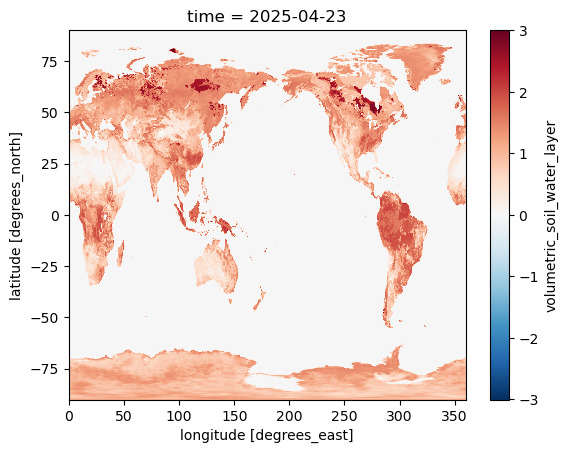

In [6]:
surface_full_19_1day['volumetric_soil_water_layer'].isel(time=0).plot()

In [7]:
import xarray as xr
import pandas as pd
# 更简单的方法：由于数据恰好是2周，直接分成前7天和后7天
# 获取第一周和第二周的数据
week1_data = surface_full_19_1day.isel(time=slice(0, 7))  # 前7天
week2_data = surface_full_19_1day.isel(time=slice(7, 14))  # 后7天

# 计算每周的平均值
week1_mean = week1_data.mean(dim='time')
week2_mean = week2_data.mean(dim='time')

# 合并为一个新的数据集，包含两周的平均值
weekly_means = xr.concat([week1_mean, week2_mean], 
                         dim=pd.Index([pd.to_datetime(week1_data.time.values[0]).strftime('%Y-%m-%d'), pd.to_datetime(week2_data.time.values[0]).strftime('%Y-%m-%d')], name='week'))

In [8]:
surface_input_weekly_means = weekly_means[['large_scale_rain_rate', 'convective_rain_rate', 'total_column_cloud_ice_water', 'total_cloud_cover', \
   'top_net_solar_radiation_clear_sky', '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'surface_latent_heat_flux', 'surface_sensible_heat_flux', 'surface_pressure', 'volumetric_soil_water_layer', \
    'mean_sea_level_pressure', 'sea_ice_cover', 'sea_surface_temperature']]

stacked_data = xr.concat([surface_input_weekly_means[var] for var in surface_input_weekly_means.data_vars], 
                         dim=xr.DataArray(list(surface_input_weekly_means.data_vars), dims='variable'))

In [9]:
var_mapping = {
    'large_scale_rain_rate': 'lsrr',
    'convective_rain_rate': 'crr',
    'total_column_cloud_ice_water': 'tciw',
    'total_cloud_cover': 'tcc',
    'top_net_solar_radiation_clear_sky': 'tsrc',
    '10m_u_component_of_wind': 'u10',
    '10m_v_component_of_wind': 'v10',
    '2m_dewpoint_temperature': 'd2m',
    '2m_temperature': 't2m',
    'surface_latent_heat_flux': 'surface_latent_heat_flux',
    'surface_sensible_heat_flux': 'surface_sensible_heat_flux',
    'surface_pressure': 'sp',
    'volumetric_soil_water_layer': 'swvl',
    'mean_sea_level_pressure': 'msl',
    'sea_ice_cover': 'siconc',
    'sea_surface_temperature': 'sst'
}

# 准备均值和标准差数组，形状为(16,1,1,1)，可以广播到(16,2,721,1440)
means = np.array([ordered_var_stats[var_mapping[var]]['mean'] for var in surface_input_weekly_means.data_vars])
stds = np.array([ordered_var_stats[var_mapping[var]]['std'] for var in surface_input_weekly_means.data_vars])

# 重塑形状用于广播
means = means.reshape(-1, 1, 1, 1)
stds = stds.reshape(-1, 1, 1, 1)

normalized_input_surface = (stacked_data.values - means) / stds

In [10]:
normalized_input_surface = np.nan_to_num(normalized_input_surface, nan=0.0)
normalized_input_surface.shape

(16, 2, 721, 1440)

## upper air

In [11]:
ds_upper_air = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None
)[['geopotential', 'vertical_velocity', 'u_component_of_wind', 'v_component_of_wind', 'fraction_of_cloud_cover', 'temperature', 'specific_humidity']]

# Select only pressure levels 300, 500, 700, 850 hPa
selected_levels = [300, 500, 700, 850]
ds_upper_air = ds_upper_air.sel(level=selected_levels)

upper_air_full_7_1day = ds_upper_air.sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))

In [11]:
import xarray as xr
import pandas as pd
# 更简单的方法：由于数据恰好是2周，直接分成前7天和后7天
# 获取第一周和第二周的数据
week1_data = upper_air_full_7_1day.isel(time=slice(0, 7))  # 前7天
week2_data = upper_air_full_7_1day.isel(time=slice(7, 14))  # 后7天

# 计算每周的平均值
week1_mean = week1_data.mean(dim='time')
week2_mean = week2_data.mean(dim='time')

# 合并为一个新的数据集，包含两周的平均值
upper_air_weekly_means = xr.concat([week1_mean, week2_mean], 
                         dim=pd.Index([pd.to_datetime(week1_data.time.values[0]).strftime('%Y-%m-%d'), pd.to_datetime(week2_data.time.values[0]).strftime('%Y-%m-%d')], name='week'))

In [12]:
upper_air_weekly_means

<xarray.Dataset>
Dimensions:                  (week: 2, level: 4, latitude: 721, longitude: 1440)
Coordinates:
  * latitude                 (latitude) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * level                    (level) int64 300 500 700 850
  * longitude                (longitude) float32 0.0 0.25 0.5 ... 359.5 359.8
  * week                     (week) object '2025-03-31' '2025-04-07'
Data variables:
    geopotential             (week, level, latitude, longitude) float32 8.249...
    vertical_velocity        (week, level, latitude, longitude) float32 0.017...
    u_component_of_wind      (week, level, latitude, longitude) float32 6.774...
    v_component_of_wind      (week, level, latitude, longitude) float32 -3.24...
    fraction_of_cloud_cover  (week, level, latitude, longitude) float32 0.0 ....
    temperature              (week, level, latitude, longitude) float32 226.8...
    specific_humidity        (week, level, latitude, longitude) float32 7.685...

In [13]:
# 按照指定的变量顺序
upper_air_vars = [
    'geopotential',
    'vertical_velocity',
    'u_component_of_wind',
    'v_component_of_wind',
    'fraction_of_cloud_cover',
    'temperature',
    'specific_humidity'
]

# 选择指定顺序的变量
upper_air_weekly_means = upper_air_weekly_means[upper_air_vars]

# 准备标准化
# 首先将数据转换为方便处理的格式
var_level_data = []
means = []
stds = []

# 对每个变量和每个气压层级，获取数据和对应的统计值
for var in upper_air_vars:
    for level in upper_air_weekly_means.level.values:
        level_str = str(level.item())
        
        # 获取该变量和层级的数据
        data = upper_air_weekly_means[var].sel(level=level)
        var_level_data.append(data)
        
        # 获取该变量和层级的均值和标准差
        means.append(ordered_var_stats[var][level_str]['mean'])
        stds.append(ordered_var_stats[var][level_str]['std'])

# 将数据合并到一个xarray数据集中
stacked_data_upper = xr.concat(var_level_data, 
                              dim=xr.DataArray([f"{var}_{level.item()}" for var in upper_air_vars 
                                               for level in upper_air_weekly_means.level.values], 
                                              dims='var_level'))

# 转换为numpy数组进行标准化
data_array = stacked_data_upper.values  # 形状为 (28, 2, 721, 1440) - 7变量×4层级×2周×格点数据

# 将均值和标准差转换为适合广播的形状
means_array = np.array(means).reshape(-1, 1, 1, 1)
stds_array = np.array(stds).reshape(-1, 1, 1, 1)

# 使用广播进行标准化
normalized_data = (data_array - means_array) / stds_array

In [14]:
normalized_input_upper_air = normalized_data.reshape(len(upper_air_vars), len(upper_air_weekly_means.level), 
                                              len(upper_air_weekly_means.week), 
                                              len(upper_air_weekly_means.latitude), 
                                              len(upper_air_weekly_means.longitude))


In [15]:
normalized_input_upper_air.shape

(7, 4, 2, 721, 1440)

# Model

In [16]:
import torch
from torch import nn
import numpy as np
from timm.models.layers import trunc_normal_, DropPath
import torch.nn.functional as F
import sys
sys.path.append('..')  # 添加上一级目录到路径
from canglong.earth_position import calculate_position_bias_indices
from canglong.shift_window import create_shifted_window_mask, partition_windows, reverse_partition
from canglong.embed import ImageToPatch2D, ImageToPatch3D, ImageToPatch4D
from canglong.recovery import RecoveryImage2D, RecoveryImage3D, RecoveryImage4D
from canglong.pad import calculate_padding_3d, calculate_padding_2d
from canglong.crop import center_crop_2d, center_crop_3d
input_constant = torch.load('../constant_masks/input_tensor.pt').cuda()

class UpSample(nn.Module):
    """
    Up-sampling operation.
    """

    def __init__(self, in_dim, out_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim * 4, bias=False)
        self.linear2 = nn.Linear(out_dim, out_dim, bias=False)
        self.norm = nn.LayerNorm(out_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

    def forward(self, x: torch.Tensor):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        x = self.linear1(x)
        x = x.reshape(B, in_pl, in_lat, in_lon, 2, 2, C // 2).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, in_pl, in_lat * 2, in_lon * 2, -1)

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        pad_h = in_lat * 2 - out_lat
        pad_w = in_lon * 2 - out_lon

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        x = x[:, :out_pl, pad_top: 2 * in_lat - pad_bottom, pad_left: 2 * in_lon - pad_right, :]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3], x.shape[4])
        x = self.norm(x)
        x = self.linear2(x)
        return x


class DownSample(nn.Module):
    """
    Down-sampling operation
    """

    def __init__(self, in_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear = nn.Linear(in_dim * 4, in_dim * 2, bias=False)
        self.norm = nn.LayerNorm(4 * in_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        h_pad = out_lat * 2 - in_lat
        w_pad = out_lon * 2 - in_lon

        pad_top = h_pad // 2
        pad_bottom = h_pad - pad_top

        pad_left = w_pad // 2
        pad_right = w_pad - pad_left

        pad_front = pad_back = 0

        self.pad = nn.ZeroPad3d(
            (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back)
        )

    def forward(self, x):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution
        x = x.reshape(B, in_pl, in_lat, in_lon, C)

        x = self.pad(x.permute(0, -1, 1, 2, 3)).permute(0, 2, 3, 4, 1)
        x = x.reshape(B, in_pl, out_lat, 2, out_lon, 2, C).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, out_pl * out_lat * out_lon, 4 * C)

        x = self.norm(x)
        x = self.linear(x)
        return x


class EarthAttention3D(nn.Module):
    """
    3D window attention with earth position bias.
    """

    def __init__(self, dim, input_resolution, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0.,
                 proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.type_of_windows = (input_resolution[0] // window_size[0]) * (input_resolution[1] // window_size[1])

        self.earth_position_bias_table = nn.Parameter(
            torch.zeros((window_size[0] ** 2) * (window_size[1] ** 2) * (window_size[2] * 2 - 1),
                        self.type_of_windows, num_heads)
        )

        earth_position_index = calculate_position_bias_indices(window_size)
        self.register_buffer("earth_position_index", earth_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.earth_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor, mask=None):
        B_, nW_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, nW_, N, 3, self.num_heads, C // self.num_heads).permute(3, 0, 4, 1, 2, 5)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        earth_position_bias = self.earth_position_bias_table[self.earth_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.type_of_windows, -1
        )
        earth_position_bias = earth_position_bias.permute(
            3, 2, 0, 1).contiguous()
        attn = attn + earth_position_bias.unsqueeze(0)

        if mask is not None:
            nLon = mask.shape[0]
            attn = attn.view(B_ // nLon, nLon, self.num_heads, nW_, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, nW_, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).permute(0, 2, 3, 1, 4).reshape(B_, nW_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class EarthSpecificBlock(nn.Module):
    """
    3D Transformer Block
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=None, shift_size=None, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        window_size = (2, 6, 12) if window_size is None else window_size
        shift_size = (1, 3, 6) if shift_size is None else shift_size
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        padding = calculate_padding_3d(input_resolution, window_size)
        self.pad = nn.ZeroPad3d(padding)

        pad_resolution = list(input_resolution)
        pad_resolution[0] += (padding[-1] + padding[-2])
        pad_resolution[1] += (padding[2] + padding[3])
        pad_resolution[2] += (padding[0] + padding[1])

        self.attn = EarthAttention3D(
            dim=dim, input_resolution=pad_resolution, window_size=window_size, num_heads=num_heads, qkv_bias=qkv_bias,
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        shift_pl, shift_lat, shift_lon = self.shift_size
        self.roll = shift_pl and shift_lon and shift_lat

        if self.roll:
            attn_mask = create_shifted_window_mask(pad_resolution, window_size, shift_size)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x: torch.Tensor):
        Pl, Lat, Lon = self.input_resolution
        B, L, C = x.shape
        assert L == Pl * Lat * Lon, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, Pl, Lat, Lon, C)

        x = self.pad(x.permute(0, 4, 1, 2, 3)).permute(0, 2, 3, 4, 1)

        _, Pl_pad, Lat_pad, Lon_pad, _ = x.shape

        shift_pl, shift_lat, shift_lon = self.shift_size
        if self.roll:
            shifted_x = torch.roll(x, shifts=(-shift_pl, -shift_lat, -shift_lon), dims=(1, 2, 3))
            x_windows = partition_windows(shifted_x, self.window_size)
        else:
            shifted_x = x
            x_windows = partition_windows(shifted_x, self.window_size)

        win_pl, win_lat, win_lon = self.window_size
        x_windows = x_windows.view(x_windows.shape[0], x_windows.shape[1], win_pl * win_lat * win_lon, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = attn_windows.view(attn_windows.shape[0], attn_windows.shape[1], win_pl, win_lat, win_lon, C)

        if self.roll:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = torch.roll(shifted_x, shifts=(shift_pl, shift_lat, shift_lon), dims=(1, 2, 3))
        else:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = shifted_x

        x = center_crop_3d(x.permute(0, 4, 1, 2, 3), self.input_resolution).permute(0, 2, 3, 4, 1)

        x = x.reshape(B, Pl * Lat * Lon, C)
        x = shortcut + self.drop_path(x)

        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x



class BasicLayer(nn.Module):
    """A basic 3D Transformer layer for one stage"""

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        self.blocks = nn.ModuleList([
            EarthSpecificBlock(dim=dim, input_resolution=input_resolution, num_heads=num_heads, window_size=window_size,
                               shift_size=(0, 0, 0) if i % 2 == 0 else None, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                               qk_scale=qk_scale, drop=drop, attn_drop=attn_drop,
                               drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                               norm_layer=norm_layer)
            for i in range(depth)
        ])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x




class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
import torch
import torch.nn as nn
from canglong.helper import ResidualBlock, NonLocalBlock, DownSampleBlock, UpSampleBlock, GroupNorm, Swish

class Encoder(nn.Module):
    def __init__(self, image_channels, latent_dim):
        super(Encoder, self).__init__()
        channels = [64, 64, 64, 128, 128]
        attn_resolutions = [2]
        num_res_blocks = 1
        resolution = 256

        # 初始卷积层
        self.conv_in = nn.Conv3d(image_channels, channels[0], kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        
        # 第一层（含残差块和注意力模块）
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks, resolution, attn_resolutions)
        
        # 下采样与第二层
        self.downsample1 = DownSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks, resolution // 2, attn_resolutions)

        # Further downsampling and third layer
        self.downsample2 = DownSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks, resolution // 4, attn_resolutions)

        # 中间层的残差块和注意力模块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 输出层的归一化、激活和最终卷积层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.Conv3d(channels[3], latent_dim, kernel_size=3, stride=1, padding=(1,2,1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks, resolution, attn_resolutions):
        layers = []
        for _ in range(num_res_blocks):
            layers.append(ResidualBlock(in_channels, out_channels))
            in_channels = out_channels
            if resolution in attn_resolutions:
                layers.append(NonLocalBlock(in_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层，并存储跳跃连接
        x = self.layer1(x)
        skip = x  # 保存第一层输出，用于后续跳跃连接

        # 下采样，进入第二层
        x = self.downsample1(x)
        x = self.layer2(x)

        # Further downsample and third layer
        x = self.downsample2(x)
        x = self.layer3(x)

        # 中间层的残差块和注意力模块
        x = self.mid_block1(x)
        #x = self.mid_attn(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)
        x = self.conv_out(x)[:, :, :, :181, :360]
        
        return x
    
class Decoder(nn.Module):
    def __init__(self, image_channels=14, latent_dim=64):
        super(Decoder, self).__init__()
        channels = [128, 128, 64, 64]  # Decoder 的通道配置
        num_res_blocks = 1  # 与 Encoder 对齐

        # 初始卷积层
        self.conv_in = nn.Conv3d(latent_dim, channels[0], kernel_size=3, stride=1, padding=1)
        
        # 第一层残差块
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks)
        
        # 上采样和第二层残差块
        self.upsample1 = UpSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks)

        self.upsample2 = UpSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks)
        
        # 中间层的残差块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 最终输出层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.ConvTranspose3d(channels[3], image_channels, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks):
        # 创建指定数量的残差块
        layers = [ResidualBlock(in_channels, out_channels) for _ in range(num_res_blocks)]
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层残差块
        x = self.layer1(x)

        # 上采样和第二层残差块
        x = self.upsample1(x)  # 上采样后通道数保持不变

        x = self.layer2(x)     # 确保输入与 layer2 的期望通道数匹配

        x = self.upsample2(x)  # 上采样后通道数保持不变

        x = self.layer3(x)     # 确保输入与 layer2 的期望通道数匹配
        
        # 中间层的残差块
        x = self.mid_block1(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)

        x = self.conv_out(x)[:, :, :, :721, :1440]
        
        return x


class Canglong(nn.Module):
    """
    CAS Canglong PyTorch impl of: `CAS-Canglong: A skillful 3D Transformer model for sub-seasonal to seasonal global sea surface temperature prediction`
    """

    def __init__(self, embed_dim=96, num_heads=(8, 16, 16, 8), window_size=(2, 6, 12)):
        super().__init__()
        drop_path = np.linspace(0, 0.2, 8).tolist()
        self.patchembed2d = ImageToPatch2D(
            img_dims=(721, 1440),
            patch_dims=(4, 4), # 8, 8
            in_channels=4,
            out_channels=embed_dim,
        )
        self.patchembed3d = ImageToPatch3D(
            img_dims=(14, 721, 1440),
            patch_dims=(1, 4, 4),
            in_channels=14,
            out_channels=embed_dim
        )
        self.patchembed4d = ImageToPatch4D(
            img_dims=(7, 4, 721, 1440),
            patch_dims=(4, 2, 4, 4),
            in_channels=7,
            out_channels=embed_dim
        )
        self.encoder3d = Encoder(image_channels=16, latent_dim=96)

        self.layer1 = BasicLayer(
            dim=embed_dim,
            input_resolution=(4, 181, 360),
            depth=2,
            num_heads=num_heads[0],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.downsample = DownSample(in_dim=embed_dim, input_resolution=(4, 181, 360), output_resolution=(4, 91, 180))
        self.layer2 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(4, 91, 180),
            depth=6,
            num_heads=num_heads[1],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.layer3 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(4, 91, 180),
            depth=6,
            num_heads=num_heads[2],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.upsample = UpSample(embed_dim * 2, embed_dim, (4, 91, 180), (4, 181, 360))
        self.layer4 = BasicLayer(
            dim=embed_dim,
            input_resolution=(4, 181, 360),
            depth=2,
            num_heads=num_heads[3],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.patchrecovery2d = RecoveryImage2D((721, 1440), (4, 4), 2 * embed_dim, 4) #8, 8
        self.decoder3d = Decoder(image_channels=16, latent_dim=2 * 96)
        self.patchrecovery3d = RecoveryImage3D(image_size=(16, 721, 1440), 
                                               patch_size=(1, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=16) #2, 8, 8
        self.patchrecovery4d = RecoveryImage4D(image_size=(7, 4, 721, 1440), 
                                               patch_size=(4, 2, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=7)
        self.conv_constant = nn.Conv2d(in_channels=4, out_channels=96, kernel_size=5, stride=4, padding=2)
        self.input_constant = input_constant


    def forward(self, surface, upper_air):
        
        
        constant = self.conv_constant(self.input_constant)
        surface = self.encoder3d(surface)

        upper_air = self.patchembed4d(upper_air)
        

        x = torch.concat([upper_air.squeeze(3), constant.unsqueeze(2), surface], dim=2)

        B, C, Pl, Lat, Lon = x.shape

        x = x.reshape(B, C, -1).transpose(1, 2)
        
        x = self.layer1(x)

        skip = x

        x = self.downsample(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.upsample(x)
        x = self.layer4(x)

        output = torch.concat([x, skip], dim=-1)
        output = output.transpose(1, 2).reshape(B, -1, Pl, Lat, Lon)

        output_surface = output[:, :, 2:, :, :]
        output_upper_air = output[:, :, 0, :, :]

        #output_surface = self.patchrecovery3d(output_surface)
        output_surface = self.decoder3d(output_surface)

        output_upper_air = self.patchrecovery4d(output_upper_air.unsqueeze(2).unsqueeze(3))

        return output_surface, output_upper_air


d:\miniconda\envs\torch\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [17]:
import torch
import numpy as np

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 假设已经有标准化后的输入数据
# normalized_input_surface: (16, 2, 721, 1440) - [变量, 周数, 纬度, 经度]
# normalized_input_upper_air: (7, 4, 2, 721, 1440) - [变量, 层级, 周数, 纬度, 经度]

# 转换为PyTorch张量
input_surface_tensor = torch.tensor(normalized_input_surface, dtype=torch.float32).unsqueeze(0)  # 添加批次维度
input_upper_air_tensor = torch.tensor(normalized_input_upper_air, dtype=torch.float32).unsqueeze(0)  # 添加批次维度

print(f"地表输入数据形状: {input_surface_tensor.shape}")  # 应为 [1, 16, 2, 721, 1440]
print(f"高空输入数据形状: {input_upper_air_tensor.shape}")  # 应为 [1, 7, 4, 2, 721, 1440]

# 加载模型
model_path = 'I:/model/model_epoch_500.pt'  # 使用最佳模型
print(f"正在从 {model_path} 加载模型...")
model = torch.load(model_path)
model.to(device)
model.eval()
print("模型加载成功")

# 设置预测的周数
forecast_weeks = 6

# 将数据移动到设备
current_input_surface = input_surface_tensor.to(device)
current_input_upper_air = input_upper_air_tensor.to(device)

# 存储滚动预报的结果
all_surface_predictions = []
all_upper_air_predictions = []

print(f"开始 {forecast_weeks} 周滚动预报...")

with torch.no_grad():
    # 滚动预报指定周数
    for week in range(forecast_weeks):
        # 前向传播
        output_surface, output_upper_air = model(current_input_surface, current_input_upper_air)
        
        # 存储当前周的预测结果
        all_surface_predictions.append(output_surface[:, :, 0:1, :, :])  # 只取第一个时间步
        all_upper_air_predictions.append(output_upper_air[:, :, :, 0:1, :, :])  # 只取第一个时间步
        
        print(f"完成第 {week+1} 周预测")
        
        if week < forecast_weeks - 1:  # 如果不是最后一周，准备下一周的输入
            # 更新输入：使用上一个时间步和新预测的时间步
            new_input_surface = torch.cat([
                current_input_surface[:, :, 1:2, :, :],  # 取当前输入的第二个时间步
                output_surface[:, :, 0:1, :, :]  # 取当前预测的第一个时间步
            ], dim=2)
            
            new_input_upper_air = torch.cat([
                current_input_upper_air[:, :, :, 1:2, :, :],  # 取当前输入的第二个时间步
                output_upper_air[:, :, :, 0:1, :, :]  # 取当前预测的第一个时间步
            ], dim=3)
            
            current_input_surface = new_input_surface
            current_input_upper_air = new_input_upper_air

# 合并所有周的预测结果
all_weeks_surface_predictions = torch.cat(all_surface_predictions, dim=2)  # [1, 16, forecast_weeks, 721, 1440]
all_weeks_upper_air_predictions = torch.cat(all_upper_air_predictions, dim=3)  # [1, 7, 4, forecast_weeks, 721, 1440]

print(f"滚动预报完成。")
print(f"所有周的地表预测形状: {all_weeks_surface_predictions.shape}")
print(f"所有周的高空预测形状: {all_weeks_upper_air_predictions.shape}")

# 将预测结果移回CPU并转换为numpy数组
surface_predictions_np = all_weeks_surface_predictions.cpu().numpy()
upper_air_predictions_np = all_weeks_upper_air_predictions.cpu().numpy()



print("可以使用denormalize_surface和denormalize_upper_air函数反标准化预测结果")
print("完成推理过程")

# 保存预测结果（可选）
# np.save('surface_predictions.npy', surface_predictions_np)
# np.save('upper_air_predictions.npy', upper_air_predictions_np)

使用设备: cuda
地表输入数据形状: torch.Size([1, 16, 2, 721, 1440])
高空输入数据形状: torch.Size([1, 7, 4, 2, 721, 1440])
正在从 I:/model/model_epoch_500.pt 加载模型...
模型加载成功
开始 6 周滚动预报...
完成第 1 周预测
完成第 2 周预测
完成第 3 周预测
完成第 4 周预测
完成第 5 周预测
完成第 6 周预测
滚动预报完成。
所有周的地表预测形状: torch.Size([1, 16, 6, 721, 1440])
所有周的高空预测形状: torch.Size([1, 7, 4, 6, 721, 1440])
可以使用denormalize_surface和denormalize_upper_air函数反标准化预测结果
完成推理过程


In [18]:
# 准备地表数据的均值和标准差数组，形状为(16,1,1,1)
surface_means = np.array([ordered_var_stats[var_mapping[var]]['mean'] for var in surface_var_names])
surface_stds = np.array([ordered_var_stats[var_mapping[var]]['std'] for var in surface_var_names])

# 重塑形状用于广播 - 注意增加了一个维度用于周数
surface_means = surface_means.reshape(-1, 1, 1, 1)
surface_stds = surface_stds.reshape(-1, 1, 1, 1)

# 使用广播一次性反标准化所有地表数据
denormalized_surface = surface_predictions_np * surface_stds + surface_means

In [19]:
denormalized_surface.shape

(1, 16, 6, 721, 1440)

In [20]:
import numpy as np
import xarray as xr
from datetime import datetime, timedelta

def data_to_xarray(denormalized_surface, demo_start_time='2025-02-01', demo_end_time='2025-02-14', forecast_weeks=6):
    """
    将反标准化的地表数据转换为xarray数据集，并计算预测时间点
    
    参数:
        denormalized_surface: 形状为(16, forecast_weeks, 721, 1440)的反标准化地表数据
        demo_start_time: 演示起始时间，格式为'YYYY-MM-DD'
        demo_end_time: 演示结束时间，格式为'YYYY-MM-DD'
        forecast_weeks: 预测的周数
    
    返回:
        surface_ds: 地表数据xarray数据集
    """
    # 定义变量名称
    surface_var_names = [
        'large_scale_rain_rate',
        'convective_rain_rate',
        'total_column_cloud_ice_water',
        'total_cloud_cover',
        'top_net_solar_radiation_clear_sky',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        '2m_dewpoint_temperature',
        '2m_temperature',
        'surface_latent_heat_flux',
        'surface_sensible_heat_flux',
        'surface_pressure',
        'volumetric_soil_water_layer',
        'mean_sea_level_pressure',
        'sea_ice_cover',
        'sea_surface_temperature'
    ]
    
    # 解析起始和结束时间
    start_date = datetime.strptime(demo_start_time, '%Y-%m-%d')
    end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
    
    # 计算预测时间点
    # 假设end_date是第二周的结束日期，我们从第三周开始预测
    forecast_start_date = end_date + timedelta(days=1)  # 从结束日期的下一天开始预测
    
    # 计算每个预测周的日期（取每周的最后一天）
    forecast_dates = []
    for i in range(forecast_weeks):
        # 每周结束日期 = 预测开始日期 + (i+1)*7 - 1 天
        week_end_date = forecast_start_date + timedelta(days=(i+1)*7-1)
        forecast_dates.append(week_end_date)
    
    # 创建坐标
    lat = np.linspace(90, -90, 721)
    lon = np.linspace(0, 359.75, 1440)
    
    # 创建地表数据的xarray数据集
    surface_ds = xr.Dataset(coords={
        'variable': surface_var_names,
        'time': forecast_dates,
        'latitude': lat,
        'longitude': lon
    })
    
    # 使用DataArray存储所有数据
    surface_data_array = xr.DataArray(
        denormalized_surface,
        dims=['variable', 'time', 'latitude', 'longitude'],
        coords={
            'variable': surface_var_names, 
            'time': forecast_dates, 
            'latitude': lat, 
            'longitude': lon
        }
    )
    
    # 将DataArray添加到Dataset中
    surface_ds['data'] = surface_data_array
    
    # 为每个变量创建单独的数据变量
    for i, var_name in enumerate(surface_var_names):
        surface_ds[var_name] = surface_data_array.sel(variable=var_name)
    
    # 计算总降水率并添加到数据集
    surface_ds['total_precipitation'] = surface_ds['large_scale_rain_rate'] + surface_ds['convective_rain_rate']
    
    # 添加预测周信息作为属性
    surface_ds.attrs['forecast_start_date'] = forecast_start_date.strftime('%Y-%m-%d')
    surface_ds.attrs['forecast_end_date'] = forecast_dates[-1].strftime('%Y-%m-%d')
    surface_ds.attrs['prediction_type'] = f"{forecast_weeks}-Week Forecast"
    surface_ds.attrs['input_data_period'] = f"{demo_start_time} to {demo_end_time}"
    
    return surface_ds

# 使用示例

# 假设我们已经有了反标准化的数据

forecast_weeks = 6

# 转换为xarray数据集
surface_ds = data_to_xarray(
    denormalized_surface[0], 
    demo_start_time=demo_start_time,
    demo_end_time=demo_end_time,
    forecast_weeks=forecast_weeks
)


print("预测时间范围:", surface_ds.attrs['forecast_start_date'], "至", surface_ds.attrs['forecast_end_date'])


预测时间范围: 2025-04-14 至 2025-05-25


In [21]:
surface_ds

<xarray.Dataset>
Dimensions:                            (variable: 16, time: 6, latitude: 721,
                                        longitude: 1440)
Coordinates:
  * variable                           (variable) <U33 'large_scale_rain_rate...
  * time                               (time) datetime64[ns] 2025-04-20 ... 2...
  * latitude                           (latitude) float64 90.0 89.75 ... -90.0
  * longitude                          (longitude) float64 0.0 0.25 ... 359.8
Data variables: (12/18)
    data                               (variable, time, latitude, longitude) float64 ...
    large_scale_rain_rate              (time, latitude, longitude) float64 -7...
    convective_rain_rate               (time, latitude, longitude) float64 -2...
    total_column_cloud_ice_water       (time, latitude, longitude) float64 0....
    total_cloud_cover                  (time, latitude, longitude) float64 0....
    top_net_solar_radiation_clear_sky  (time, latitude, longitude) float64 4....
    ...                                 ...
    surface_pressure                   (time, latitude, longitude) float64 9....
    volumetric_soil_water_layer        (time, latitude, longitude) float64 -0...
    mean_sea_level_pressure            (time, latitude, longitude) float64 1....
    sea_ice_cover                      (time, latitude, longitude) float64 0....
    sea_surface_temperature            (time, latitude, longitude) float64 26...
    total_precipitation                (time, latitude, longitude) float64 -3...
Attributes:
    forecast_start_date:  2025-04-14
    forecast_end_date:    2025-05-25
    prediction_type:      6-Week Forecast
    input_data_period:    2025-03-31 to 2025-04-13

In [22]:
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 定义时间范围

forecast_weeks = 6

# 计算预测时间点
end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
forecast_start_date = end_date + timedelta(days=1)  # 从结束日期的下一天开始预测

# 计算每个预测周的结束日期
forecast_dates = []
for i in range(forecast_weeks):
    # 每周结束日期 = 预测开始日期 + (i+1)*7 - 1 天
    week_end_date = forecast_start_date + timedelta(days=(i+1)*7-1)
    forecast_dates.append(week_end_date)

# 计算预测期间的ERA5数据时间范围
validation_start_date = forecast_start_date.strftime('%Y-%m-%d')
validation_end_date = forecast_dates[-1].strftime('%Y-%m-%d')

print(f"预测开始日期: {validation_start_date}")
print(f"预测结束日期: {validation_end_date}")

# 下载ERA5预测期间的真实数据
print(f"正在下载ERA5数据，从 {validation_start_date} 到 {validation_end_date}")

# 下载地表数据
ds_surface = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None
)[['large_scale_rain_rate', 'convective_rain_rate', 'total_column_cloud_ice_water', 'total_cloud_cover',
   'top_net_solar_radiation_clear_sky', '10m_u_component_of_wind', '10m_v_component_of_wind', 
   '2m_dewpoint_temperature', '2m_temperature', 'surface_latent_heat_flux', 'surface_sensible_heat_flux', 
   'surface_pressure', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 
   'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',
   'mean_sea_level_pressure', 'sea_ice_cover', 'sea_surface_temperature']]

# 选择预测期间的数据
surface_validation = ds_surface.sel(time=slice(validation_start_date, validation_end_date))

# 计算土壤水层总量
surface_validation['volumetric_soil_water_layer'] = (
    surface_validation['volumetric_soil_water_layer_1'] + 
    surface_validation['volumetric_soil_water_layer_2'] + 
    surface_validation['volumetric_soil_water_layer_3'] + 
    surface_validation['volumetric_soil_water_layer_4']
)

print('下载完成，开始计算每周平均值')
# 按照与预测结果相同的方式，计算每周平均值
weekly_validation_data = []

for i in range(forecast_weeks):
    week_start = forecast_start_date + timedelta(days=i*7)
    week_end = week_start + timedelta(days=6)
    
    # 选择当前周的数据
    week_data = surface_validation.sel(
        time=slice(week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d'))
    )
    
    # 计算该周的平均值
    week_mean = week_data.mean(dim='time')
    weekly_validation_data.append(week_mean)

# 合并所有周的数据
validation_ds = xr.concat(weekly_validation_data, 
                          dim=pd.Index([d.strftime('%Y-%m-%d') for d in forecast_dates], name='time'))

# 选择与预测相同的变量
validation_ds = validation_ds[['large_scale_rain_rate', 'convective_rain_rate', 'total_column_cloud_ice_water', 
                              'total_cloud_cover', 'top_net_solar_radiation_clear_sky', 
                              '10m_u_component_of_wind', '10m_v_component_of_wind', 
                              '2m_dewpoint_temperature', '2m_temperature', 'surface_latent_heat_flux', 
                              'surface_sensible_heat_flux', 'surface_pressure', 
                              'volumetric_soil_water_layer', 'mean_sea_level_pressure', 
                              'sea_ice_cover', 'sea_surface_temperature']]

# 计算总降水率
validation_ds['total_precipitation'] = validation_ds['large_scale_rain_rate'] + validation_ds['convective_rain_rate']

print(f"ERA5验证数据准备完成，形状: {validation_ds.dims}")

# 假设我们已经有了Canglong模型的预测结果
# predictions_ds = ...  # 从之前的预测结果加载

# 加载之前的预测结果
predictions_ds = surface_ds

预测开始日期: 2025-02-15
预测结束日期: 2025-03-28
正在下载ERA5数据，从 2025-02-15 到 2025-03-28
下载完成，开始计算每周平均值
ERA5验证数据准备完成，形状: Frozen({'time': 6, 'latitude': 721, 'longitude': 1440})


## 全球对比分析

In [23]:
validation_ds['time'] = pd.to_datetime(validation_ds.time.values)
predictions_ds['time'] = pd.to_datetime(predictions_ds.time.values)
common_vars = list(set(validation_ds.data_vars).intersection(set(predictions_ds.data_vars)))
validation_ds = validation_ds[common_vars]
predictions_ds = predictions_ds[common_vars]
combined_ds = xr.concat([validation_ds, predictions_ds], dim=pd.Index(['ERA5', 'Canglong'], name='model'))

In [24]:
combined_ds.to_netcdf('era5_vs_canglong_6weeks.nc')

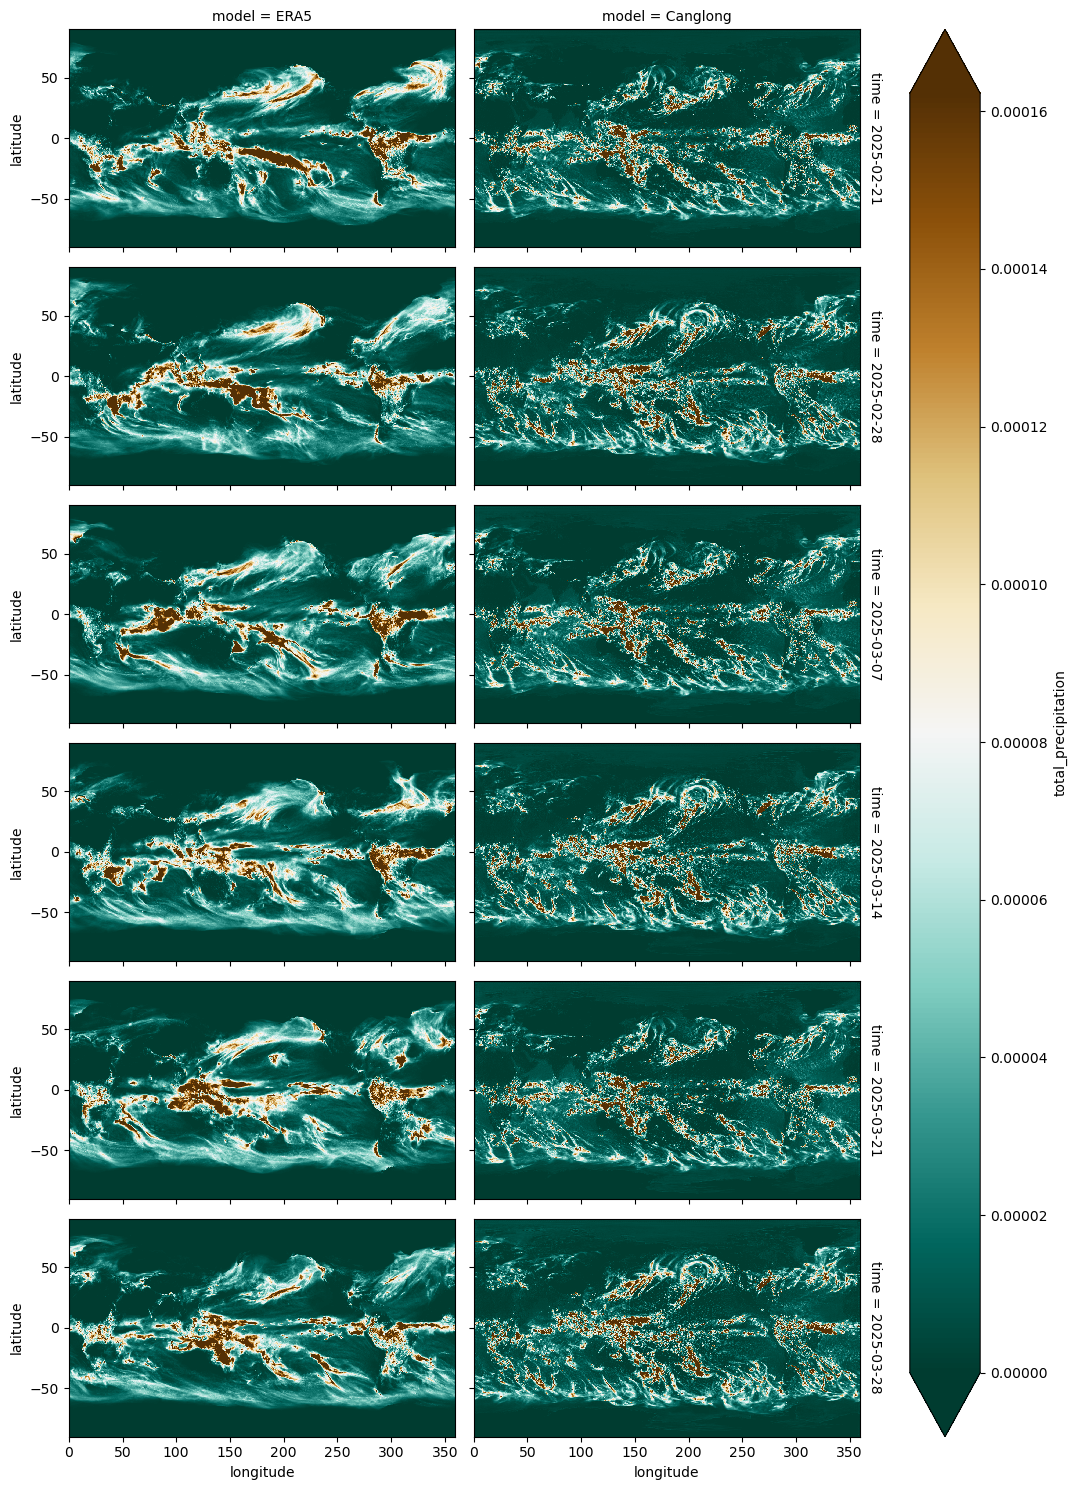

In [25]:
combined_ds.total_precipitation.plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2.5, vmin=0, cmap='BrBG_r'
)

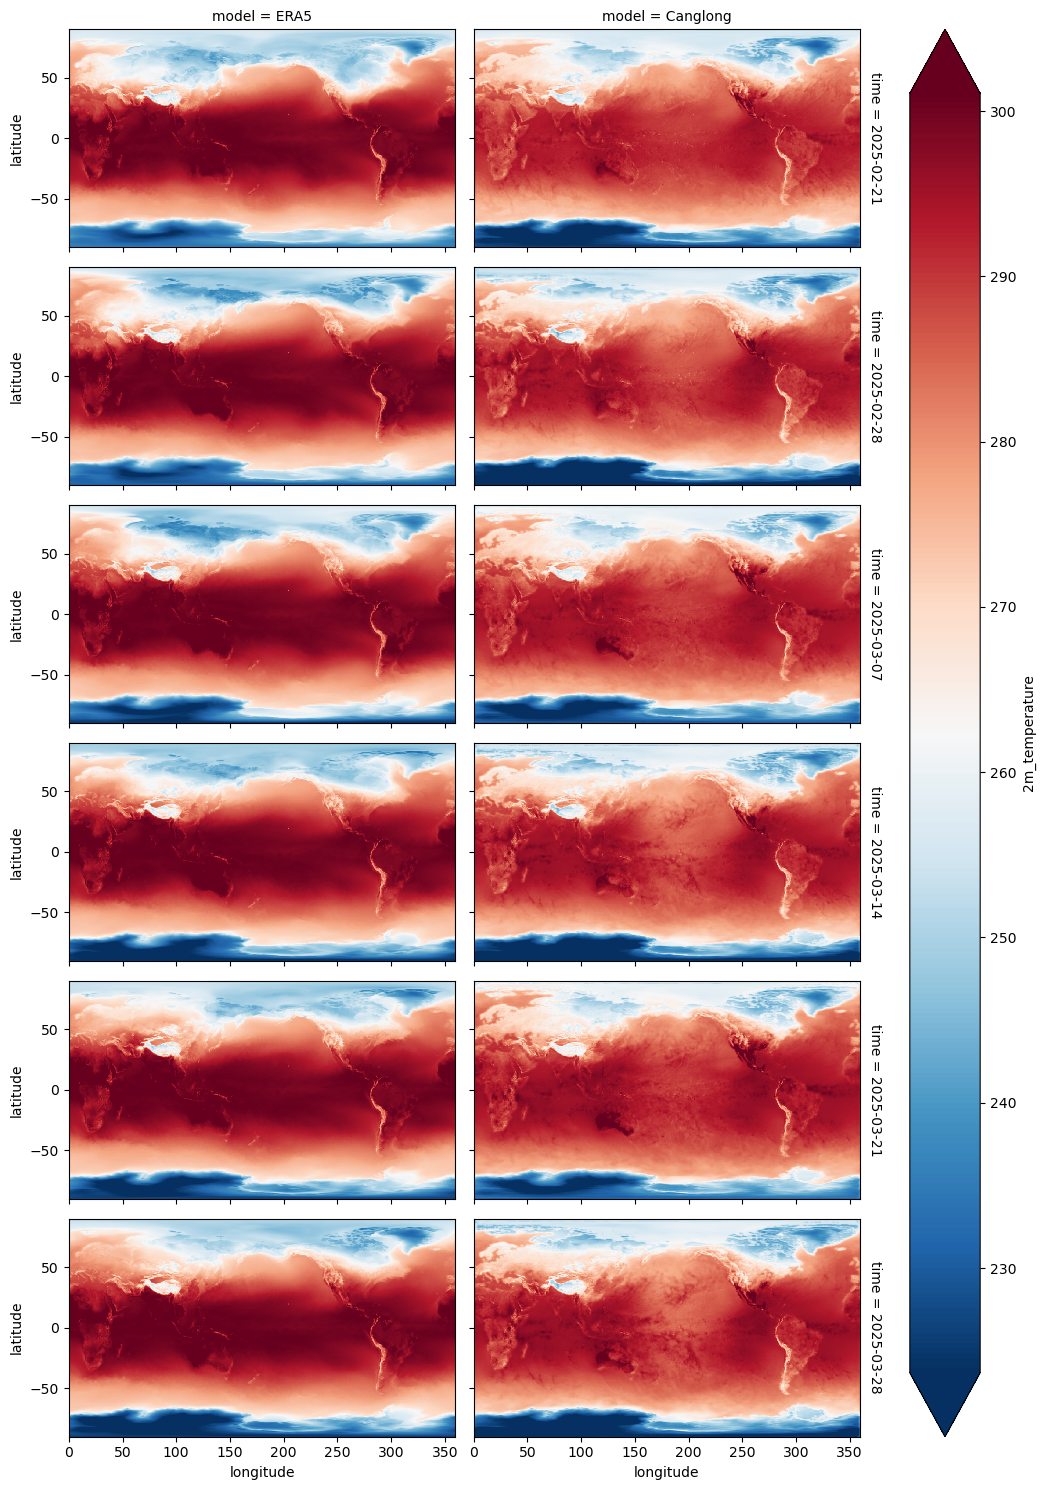

In [26]:
combined_ds['2m_temperature'].plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2.5, cmap='RdBu_r'
)

## 风速回报

In [29]:
surface_ds = data_to_xarray(
    denormalized_surface[0], 
    demo_start_time=demo_start_time,
    demo_end_time=demo_end_time,
    forecast_weeks=forecast_weeks
)

In [31]:
surface_ds.to_netcdf('canglong_6weeks_4.13_5.18.nc')

In [3]:
# 计算风速 (wind speed) 从 u 和 v 分量
# 使用毕达哥拉斯定理: wind_speed = sqrt(u² + v²)
import xarray as xr
import numpy as np
surface_ds = xr.open_dataset('canglong_6weeks_4.13_5.18.nc')
wind_speed = np.sqrt(surface_ds['10m_u_component_of_wind']**2 + surface_ds['10m_v_component_of_wind']**2)

# 将风速添加到数据集中
surface_ds['wind_speed'] = wind_speed
surface_ds['wind_speed'].attrs['long_name'] = '10m Wind Speed'
surface_ds['wind_speed'].attrs['units'] = 'm/s'

# 显示数据集，包括新计算的风速
surface_ds

<xarray.Dataset>
Dimensions:                            (variable: 16, time: 6, latitude: 721,
                                        longitude: 1440)
Coordinates:
  * variable                           (variable) object 'large_scale_rain_ra...
  * time                               (time) datetime64[ns] 2025-04-13 ... 2...
  * latitude                           (latitude) float64 90.0 89.75 ... -90.0
  * longitude                          (longitude) float64 0.0 0.25 ... 359.8
Data variables: (12/19)
    data                               (variable, time, latitude, longitude) float64 ...
    large_scale_rain_rate              (time, latitude, longitude) float64 ...
    convective_rain_rate               (time, latitude, longitude) float64 ...
    total_column_cloud_ice_water       (time, latitude, longitude) float64 ...
    total_cloud_cover                  (time, latitude, longitude) float64 ...
    top_net_solar_radiation_clear_sky  (time, latitude, longitude) float64 ...
    ...                                 ...
    volumetric_soil_water_layer        (time, latitude, longitude) float64 ...
    mean_sea_level_pressure            (time, latitude, longitude) float64 ...
    sea_ice_cover                      (time, latitude, longitude) float64 ...
    sea_surface_temperature            (time, latitude, longitude) float64 ...
    total_precipitation                (time, latitude, longitude) float64 ...
    wind_speed                         (time, latitude, longitude) float64 0....
Attributes:
    forecast_start_date:  2025-04-07
    forecast_end_date:    2025-05-18
    prediction_type:      6-Week Forecast
    input_data_period:    2025-03-24 to 2025-04-06

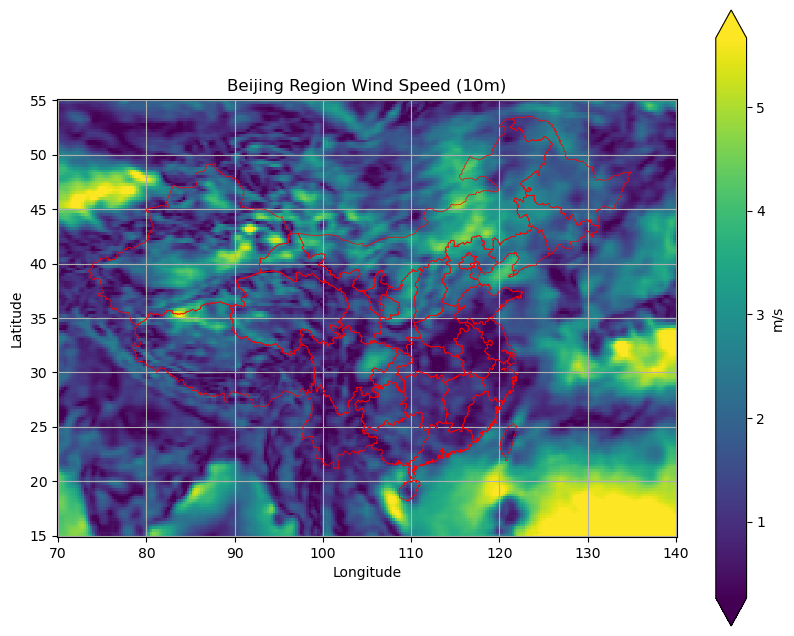

In [ ]:

beijing_wind = surface_ds['wind_speed'].sel(
    longitude=slice(70, 140),
    latitude=slice(55, 15)  # 注意纬度是从北到南排列的，所以高纬度在前
)

# 导入用于读取shapefile的库
import geopandas as gpd
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# 绘制北京地区的风速
plt.figure(figsize=(10, 8))
ax = plt.axes()

# 绘制风速数据
beijing_wind.isel(time=0).plot(
    ax=ax,
    cmap='viridis',
    robust=True,
    cbar_kwargs={'label': 'm/s'}
)

# 读取北京边界shapefile
beijing_shp = gpd.read_file(r'D:\Onedrive\data\china.shp')

# 将shapefile添加到图中
beijing_shp.boundary.plot(ax=ax, color='red', linewidth=0.5)

plt.title('Beijing Region Wind Speed (10m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()



C:\Users\DELL\AppData\Local\Temp\ipykernel_55492\372125138.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  beaufort_cmap = plt.cm.get_cmap('viridis', num_levels)


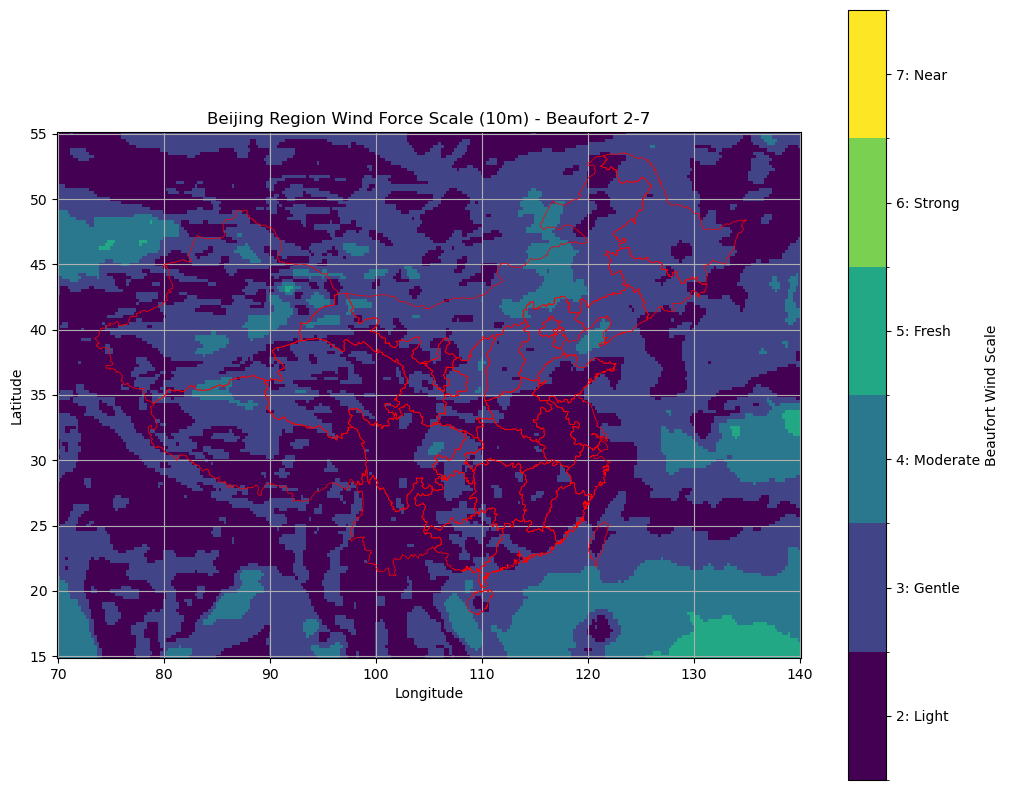

In [62]:
# 截取北京地区 (东经115.7°--117.4°，北纬39.4°--41.6°)
beijing_wind = surface_ds['wind_speed'].sel(
    longitude=slice(70, 140),
    latitude=slice(55, 15)  # 注意纬度是从北到南排列的，所以高纬度在前
)

# 导入用于读取shapefile的库
import geopandas as gpd
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# 设置风力等级范围参数
wind_min = 2  # 最小风力等级
wind_max = 7  # 最大风力等级

# 定义风速到蒲福风力等级的转换函数
def wind_speed_to_beaufort(wind_speed):
    """将风速(m/s)转换为蒲福风力等级"""
    beaufort_scale = {
        0: -1.3,   # < 0.3 m/s
        1: -0.6,   # 0.3-1.5 m/s
        2: 1.4,   # 1.6-3.3 m/s
        3: 3.5,   # 3.4-5.4 m/s
        4: 6.0,   # 5.5-7.9 m/s
        5: 8.8,  # 8.0-10.7 m/s
        6: 11.9,  # 10.8-13.8 m/s
        7: 15.2,  # 13.9-17.1 m/s
        8: 18.8,  # 17.2-20.7 m/s
        9: 22.5,  # 20.8-24.4 m/s
        10: 26.5, # 24.5-28.4 m/s
        11: 30.7, # 28.5-32.6 m/s
        12: float('inf')  # ≥ 32.7 m/s
    }
    
    for grade, threshold in beaufort_scale.items():
        if wind_speed < threshold:
            return grade
    return 12

# 将蒲福风力等级限制在指定的范围内
def limit_beaufort_scale(beaufort, min_grade, max_grade):
    """将风力等级限制在指定范围内"""
    if beaufort < min_grade:
        return min_grade
    elif beaufort > max_grade:
        return max_grade
    else:
        return beaufort

# 风力等级描述（英文）
beaufort_descriptions = {
    0: 'Calm (< 0.3 m/s)',
    1: 'Light Air (0.3-1.5 m/s)',
    2: 'Light Breeze (1.6-3.3 m/s)',
    3: 'Gentle Breeze (3.4-5.4 m/s)',
    4: 'Moderate Breeze (5.5-7.9 m/s)',
    5: 'Fresh Breeze (8.0-10.7 m/s)',
    6: 'Strong Breeze (10.8-13.8 m/s)',
    7: 'Near Gale (13.9-17.1 m/s)',
    8: 'Gale (17.2-20.7 m/s)',
    9: 'Strong Gale (20.8-24.4 m/s)',
    10: 'Storm (24.5-28.4 m/s)',
    11: 'Violent Storm (28.5-32.6 m/s)',
    12: 'Hurricane (≥ 32.7 m/s)'
}

# 将风速数据转换为风力等级
wind_data = beijing_wind.isel(time=0).values
# 首先转换为蒲福风力等级
beaufort_data = np.vectorize(wind_speed_to_beaufort)(wind_data)
# 然后限制在指定范围内
limited_beaufort_data = np.vectorize(lambda x: limit_beaufort_scale(x, wind_min, wind_max))(beaufort_data)

# 创建自定义的色标和标签
num_levels = wind_max - wind_min + 1
beaufort_cmap = plt.cm.get_cmap('viridis', num_levels)
norm = colors.BoundaryNorm(np.arange(wind_min - 0.5, wind_max + 1.5, 1), beaufort_cmap.N)

# 绘制北京地区的风力等级
plt.figure(figsize=(12, 10))
ax = plt.axes()

# 绘制风力等级数据
im = ax.pcolormesh(
    beijing_wind.longitude.values,
    beijing_wind.latitude.values,
    limited_beaufort_data,
    cmap=beaufort_cmap,
    norm=norm
)

# 添加色标
cbar = plt.colorbar(im, ax=ax, ticks=range(wind_min, wind_max + 1))
cbar.set_label('Beaufort Wind Scale')

# 设置色标标签为风力等级描述
cbar_labels = [f"{i}: {beaufort_descriptions[i].split(' ')[0]}" for i in range(wind_min, wind_max + 1)]
cbar.ax.set_yticklabels(cbar_labels)

# 读取北京边界shapefile
beijing_shp = gpd.read_file(r'D:\Onedrive\data\china.shp')

# 将shapefile添加到图中
beijing_shp.boundary.plot(ax=ax, color='red', linewidth=0.5)

plt.title(f'Beijing Region Wind Force Scale (10m) - Beaufort {wind_min}-{wind_max}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

d:\miniconda\envs\geo\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


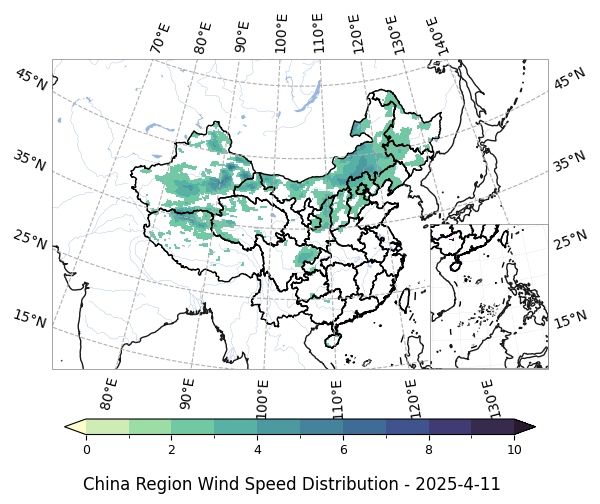

In [39]:
# 选择中国区域的风速数据
china_wind = surface_ds['wind_speed'].sel(
    longitude=slice(70, 140),
    latitude=slice(55, 15)  # 注意纬度是从北到南排列的，所以高纬度在前
)

# 导入必要的库
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import salem
import cmaps
import cartopy.crs as ccrs
from utils import plot

# 读取中国边界shapefile
china_shp = gpd.read_file(r'D:\Onedrive\data\china.shp')

# 使用salem创建掩膜
# 将数据转换为salem.DataArray以便使用salem的功能
ds = salem.DataArrayAccessor(china_wind.isel(time=0))
# 使用salem的roi方法创建掩膜
masked_da = ds.roi(shape=china_shp)

# 应用掩膜：只显示中国陆地上的风力数据
masked_wind_data = masked_da.copy()
# 将风速小于2的区域设为NaN
masked_wind_data.values[masked_wind_data.values < 2] = np.nan

# 设置风速范围
vmin, vmax = 0, 10  # 风速范围从0到10 m/s
levels = np.linspace(vmin, vmax, 11)  # 创建10个等间隔的级别

# 创建图形和投影
fig = plt.figure()
proj = ccrs.LambertConformal(central_longitude=105, 
                            central_latitude=40,
                            standard_parallels=(25.0, 47.0))
ax = fig.add_subplot(111, projection=proj)

# 使用plot包绘制中国地区的风速分布
plot.one_map_china(
    masked_wind_data, 
    ax, 
    cmap=cmaps.cmocean_deep, 
    levels=levels,
    mask_ocean=False, 
    add_coastlines=True, 
    add_land=False, 
    add_river=True, 
    add_lake=True, 
    add_stock=False, 
    add_gridlines=True, 
    colorbar=True, 
    plotfunc="pcolormesh"
)

# 获取当前时间
current_time = china_wind.time.values[0]
time_str = np.datetime_as_string(current_time, unit='D')

# 设置标题
# 设置标题在图的底部
fig.suptitle(f'China Region Wind Speed Distribution - 2025-4-11', y=-0.05)

# 添加小地图
ax2 = fig.add_axes([0.708, 0.174, 0.2, 0.3], projection=proj)
plot.sub_china_map(masked_wind_data, ax2, add_coastlines=True, add_land=False)

plt.show()

## 其它变量回报

C:\Users\DELL\AppData\Local\Temp\ipykernel_42492\2916119148.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 调整布局以适应色标


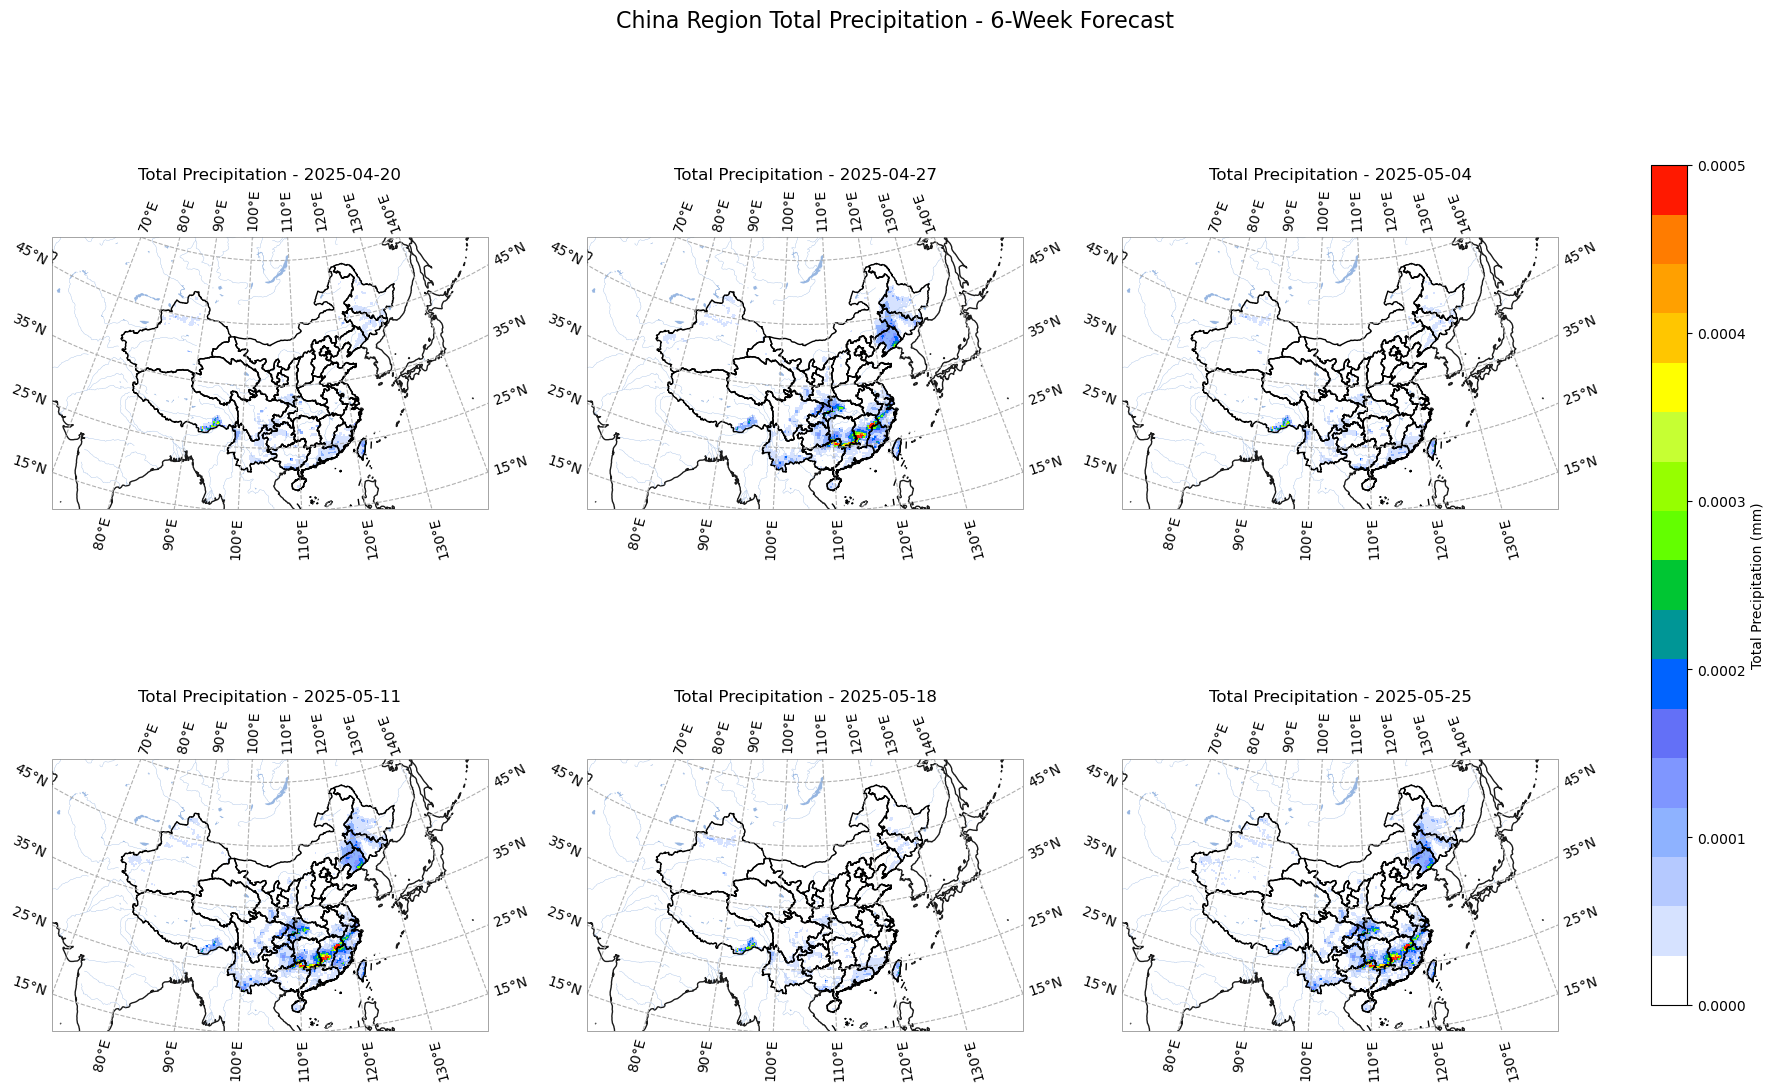

In [23]:
# 定义可选变量
variable_name = 'total_precipitation'  # 可以改为 'total_precipitation', 'wind_speed' 或其他变量

# 选择中国区域的数据
china_data = surface_ds[variable_name].sel(
    longitude=slice(70, 140),
    latitude=slice(55, 15)  # 注意纬度是从北到南排列的，所以高纬度在前
)

# 导入必要的库
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import salem
import cmaps
import cartopy.crs as ccrs
from utils import plot

# 读取中国边界shapefile
china_shp = gpd.read_file(r'D:\Onedrive\data\china.shp')

# 使用salem创建掩膜
# 将数据转换为salem.DataArray以便使用salem的功能
ds = salem.DataArrayAccessor(china_data.isel(time=0))
# 使用salem的roi方法创建掩膜
masked_da = ds.roi(shape=china_shp)

# 应用掩膜：只显示中国陆地上的数据
masked_data = masked_da.copy()

# 根据变量设置合适的色标和范围
if variable_name == 'wind_speed':
    data_cmap = cmaps.cmocean_deep
    vmin, vmax = 0, 10  # 风速范围从0到10 m/s
    unit_label = 'm/s'
    title_prefix = 'Wind Speed'
elif variable_name == 'total_precipitation':
    data_cmap = cmaps.precip3_16lev  # 使用尖尖的降水色卡
    vmin, vmax = 0, 0.0005  # 直接设置降水范围，不标准化
    unit_label = 'mm'
    title_prefix = 'Total Precipitation'
elif variable_name == '2m_temperature':
    data_cmap = cmaps.temp_diff_18lev  # 使用温度色卡
    # 将开尔文温度转换为摄氏度
    china_data = china_data - 273.15
    # 自动确定数据范围
    all_data = china_data.values
    vmin, vmax = np.nanpercentile(all_data, [5, 95])
    unit_label = '°C'  # 更改为摄氏度单位
    title_prefix = '2m Temperature'
else:
    data_cmap = plt.cm.viridis
    # 自动确定数据范围
    all_data = china_data.values
    vmin, vmax = np.nanpercentile(all_data, [5, 95])
    unit_label = ''
    title_prefix = variable_name.replace('_', ' ').title()

# 创建图形和投影
fig = plt.figure(figsize=(18, 12))
proj = ccrs.LambertConformal(central_longitude=105, 
                            central_latitude=40,
                            standard_parallels=(25.0, 47.0))

# 创建2x3的子图布局
axes = []
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection=proj)
    axes.append(ax)

# 设置等值线级别
levels = np.linspace(vmin, vmax, 11)  # 创建10个等间隔的级别

# 创建一个标准化对象，确保色标和绘图使用相同的映射
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# 遍历所有时间点
for t in range(6):
    ax = axes[t]
    
    # 获取当前时间点的数据
    current_data = china_data.isel(time=t)
    # 将数据转换为salem.DataArray
    ds_t = salem.DataArrayAccessor(current_data)
    # 使用salem的roi方法创建掩膜
    masked_data_t = ds_t.roi(shape=china_shp)
    
    # 将降水小于0.0001的区域设为NaN
    if variable_name == 'total_precipitation':
        masked_data_t.values[masked_data_t.values < 0.00001] = np.nan
    
    # 使用plot包绘制中国地区的数据分布，并传入norm参数确保颜色映射一致
    plot.one_map_china(
        masked_data_t, 
        ax, 
        cmap=data_cmap, 
        levels=levels,
        norm=norm,  # 添加标准化对象
        mask_ocean=False, 
        add_coastlines=True, 
        add_land=False, 
        add_river=True, 
        add_lake=True, 
        add_stock=False, 
        add_gridlines=True, 
        colorbar=False, 
        plotfunc="pcolormesh"
    )
    
    # 获取当前时间
    current_time = china_data.time.values[t]
    time_str = np.datetime_as_string(current_time, unit='D')
    
    # 设置标题
    ax.set_title(f'{title_prefix} - {time_str}')

# 添加共享的色标，使用相同的标准化对象
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=data_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(f'{title_prefix} ({unit_label})')

plt.suptitle(f'China Region {title_prefix} - 6-Week Forecast', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 调整布局以适应色标
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_42492\3776176663.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 调整布局以适应色标


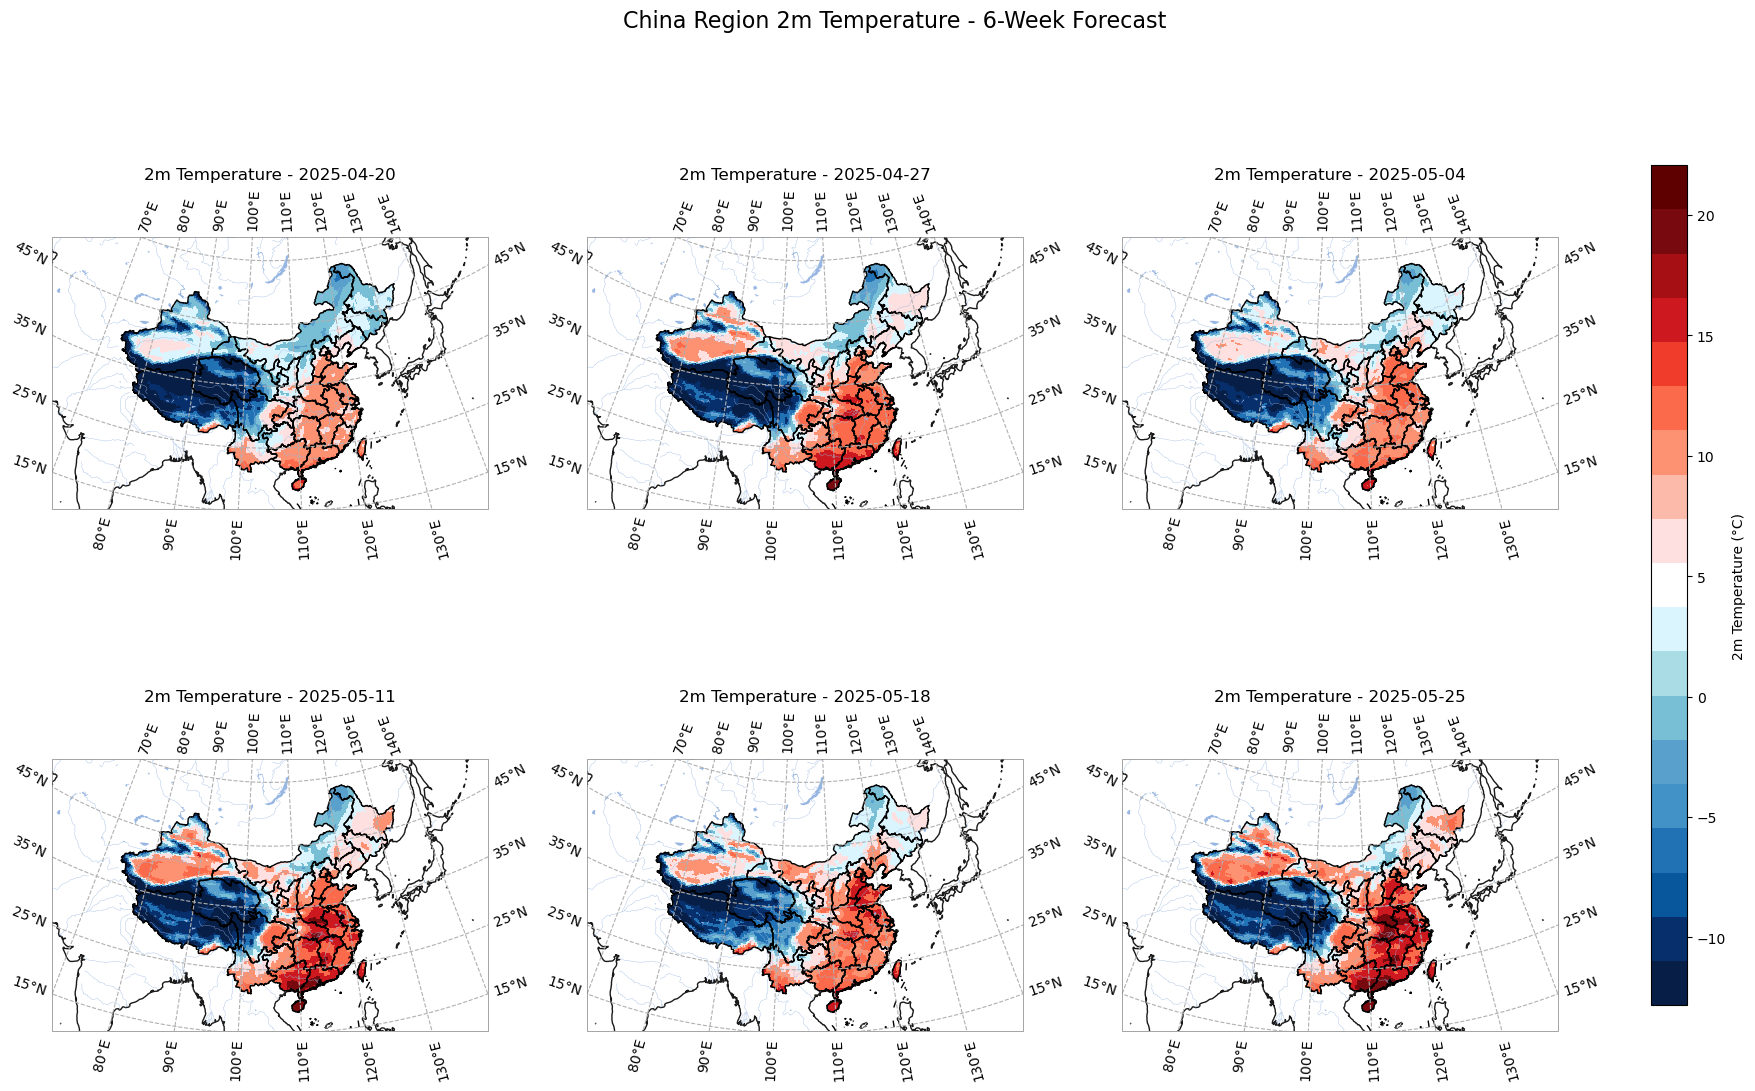

In [25]:
# 定义可选变量
variable_name = '2m_temperature'  # 可以改为 'total_precipitation', 'wind_speed' 或其他变量

# 选择中国区域的数据
china_data = surface_ds[variable_name].sel(
    longitude=slice(70, 140),
    latitude=slice(55, 15)  # 注意纬度是从北到南排列的，所以高纬度在前
)

# 导入必要的库
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import salem
import cmaps
import cartopy.crs as ccrs
from utils import plot

# 读取中国边界shapefile
china_shp = gpd.read_file(r'D:\Onedrive\data\china.shp')

# 使用salem创建掩膜
# 将数据转换为salem.DataArray以便使用salem的功能
ds = salem.DataArrayAccessor(china_data.isel(time=0))
# 使用salem的roi方法创建掩膜
masked_da = ds.roi(shape=china_shp)

# 应用掩膜：只显示中国陆地上的数据
masked_data = masked_da.copy()

# 根据变量设置合适的色标和范围
if variable_name == 'wind_speed':
    data_cmap = cmaps.cmocean_deep
    vmin, vmax = 0, 10  # 风速范围从0到10 m/s
    unit_label = 'm/s'
    title_prefix = 'Wind Speed'
elif variable_name == 'total_precipitation':
    data_cmap = cmaps.precip3_16lev  # 使用尖尖的降水色卡
    vmin, vmax = 0, 0.0005  # 直接设置降水范围，不标准化
    unit_label = 'mm'
    title_prefix = 'Total Precipitation'
elif variable_name == '2m_temperature':
    data_cmap = cmaps.temp_diff_18lev  # 使用温度色卡
    # 将开尔文温度转换为摄氏度
    china_data = china_data - 273.15
    # 自动确定数据范围
    all_data = china_data.values
    vmin, vmax = np.nanpercentile(all_data, [5, 95])
    unit_label = '°C'  # 更改为摄氏度单位
    title_prefix = '2m Temperature'
else:
    data_cmap = plt.cm.viridis
    # 自动确定数据范围
    all_data = china_data.values
    vmin, vmax = np.nanpercentile(all_data, [5, 95])
    unit_label = ''
    title_prefix = variable_name.replace('_', ' ').title()

# 创建图形和投影
fig = plt.figure(figsize=(18, 12))
proj = ccrs.LambertConformal(central_longitude=105, 
                            central_latitude=40,
                            standard_parallels=(25.0, 47.0))

# 创建2x3的子图布局
axes = []
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection=proj)
    axes.append(ax)

# 设置等值线级别
levels = np.linspace(vmin, vmax, 11)  # 创建10个等间隔的级别

# 创建一个标准化对象，确保色标和绘图使用相同的映射
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# 遍历所有时间点
for t in range(6):
    ax = axes[t]
    
    # 获取当前时间点的数据
    current_data = china_data.isel(time=t)
    # 将数据转换为salem.DataArray
    ds_t = salem.DataArrayAccessor(current_data)
    # 使用salem的roi方法创建掩膜
    masked_data_t = ds_t.roi(shape=china_shp)
    
    # 将降水小于0.0001的区域设为NaN
    if variable_name == 'total_precipitation':
        masked_data_t.values[masked_data_t.values < 0.00001] = np.nan
    
    # 使用plot包绘制中国地区的数据分布，并传入norm参数确保颜色映射一致
    plot.one_map_china(
        masked_data_t, 
        ax, 
        cmap=data_cmap, 
        levels=levels,
        norm=norm,  # 添加标准化对象
        mask_ocean=False, 
        add_coastlines=True, 
        add_land=False, 
        add_river=True, 
        add_lake=True, 
        add_stock=False, 
        add_gridlines=True, 
        colorbar=False, 
        plotfunc="pcolormesh"
    )
    
    # 获取当前时间
    current_time = china_data.time.values[t]
    time_str = np.datetime_as_string(current_time, unit='D')
    
    # 设置标题
    ax.set_title(f'{title_prefix} - {time_str}')

# 添加共享的色标，使用相同的标准化对象
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=data_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(f'{title_prefix} ({unit_label})')

plt.suptitle(f'China Region {title_prefix} - 6-Week Forecast', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 调整布局以适应色标
plt.show()

## 距平回报

In [26]:
surface_ds

<xarray.Dataset>
Dimensions:                            (variable: 16, time: 6, latitude: 721,
                                        longitude: 1440)
Coordinates:
  * variable                           (variable) <U33 'large_scale_rain_rate...
  * time                               (time) datetime64[ns] 2025-04-20 ... 2...
  * latitude                           (latitude) float64 90.0 89.75 ... -90.0
  * longitude                          (longitude) float64 0.0 0.25 ... 359.8
Data variables: (12/18)
    data                               (variable, time, latitude, longitude) float64 ...
    large_scale_rain_rate              (time, latitude, longitude) float64 -7...
    convective_rain_rate               (time, latitude, longitude) float64 -2...
    total_column_cloud_ice_water       (time, latitude, longitude) float64 0....
    total_cloud_cover                  (time, latitude, longitude) float64 0....
    top_net_solar_radiation_clear_sky  (time, latitude, longitude) float64 4....
    ...                                 ...
    surface_pressure                   (time, latitude, longitude) float64 9....
    volumetric_soil_water_layer        (time, latitude, longitude) float64 -0...
    mean_sea_level_pressure            (time, latitude, longitude) float64 1....
    sea_ice_cover                      (time, latitude, longitude) float64 0....
    sea_surface_temperature            (time, latitude, longitude) float64 26...
    total_precipitation                (time, latitude, longitude) float64 -3...
Attributes:
    forecast_start_date:  2025-04-14
    forecast_end_date:    2025-05-25
    prediction_type:      6-Week Forecast
    input_data_period:    2025-03-31 to 2025-04-13

In [ ]:
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 定义平均态范围 - 使用2000年的数据作为基准
base_year = '2000'
forecast_weeks = 6

# 从surface_ds中获取预测的时间范围
forecast_dates = pd.to_datetime(surface_ds.time.values)
forecast_start_date = forecast_dates[0]
forecast_end_date = forecast_dates[-1]

# 计算2000年对应的同期日期
base_start_date = datetime(2000, forecast_start_date.month, forecast_start_date.day)
base_end_date = datetime(2000, forecast_end_date.month, forecast_end_date.day)

print(f"预测时间范围: {forecast_start_date.strftime('%Y-%m-%d')} 到 {forecast_end_date.strftime('%Y-%m-%d')}")
print(f"基准时间范围: {base_start_date.strftime('%Y-%m-%d')} 到 {base_end_date.strftime('%Y-%m-%d')}")

# 下载2000年同期的ERA5数据
print(f"正在下载2000年ERA5基准数据，从 {base_start_date.strftime('%Y-%m-%d')} 到 {base_end_date.strftime('%Y-%m-%d')}")

# 下载地表数据
ds_base = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None
)[['large_scale_rain_rate', 'convective_rain_rate', 'total_column_cloud_ice_water', 'total_cloud_cover',
   'top_net_solar_radiation_clear_sky', '10m_u_component_of_wind', '10m_v_component_of_wind', 
   '2m_dewpoint_temperature', '2m_temperature', 'surface_latent_heat_flux', 'surface_sensible_heat_flux', 
   'surface_pressure', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 
   'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',
   'mean_sea_level_pressure', 'sea_ice_cover', 'sea_surface_temperature']]

# 选择基准年份的数据
base_data = ds_base.sel(time=slice(base_start_date.strftime('%Y-%m-%d'), base_end_date.strftime('%Y-%m-%d')))

# 计算土壤水层总量
base_data['volumetric_soil_water_layer'] = (
    base_data['volumetric_soil_water_layer_1'] + 
    base_data['volumetric_soil_water_layer_2'] + 
    base_data['volumetric_soil_water_layer_3'] + 
    base_data['volumetric_soil_water_layer_4']
)

print('下载完成，开始计算每周平均值')

# 按照与预测结果相同的方式，计算每周平均值
weekly_base_data = []

# 为2000年的每个对应周计算平均值
for i in range(forecast_weeks):
    # 计算2000年对应的周起止日期
    week_start = base_start_date + timedelta(days=i*7)
    week_end = week_start + timedelta(days=6)
    
    # 选择当前周的数据
    week_data = base_data.sel(
        time=slice(week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d'))
    )
    
    # 计算该周的平均值
    week_mean = week_data.mean(dim='time')
    weekly_base_data.append(week_mean)

# 合并所有周的数据
base_ds = xr.concat(weekly_base_data, 
                    dim=pd.Index([d.strftime('%Y-%m-%d') for d in forecast_dates], name='time'))

# 选择与预测相同的变量
base_ds = base_ds[['large_scale_rain_rate', 'convective_rain_rate', 'total_column_cloud_ice_water', 
                  'total_cloud_cover', 'top_net_solar_radiation_clear_sky', 
                  '10m_u_component_of_wind', '10m_v_component_of_wind', 
                  '2m_dewpoint_temperature', '2m_temperature', 'surface_latent_heat_flux', 
                  'surface_sensible_heat_flux', 'surface_pressure', 
                  'volumetric_soil_water_layer', 'mean_sea_level_pressure', 
                  'sea_ice_cover', 'sea_surface_temperature']]

# 计算总降水率
base_ds['total_precipitation'] = base_ds['large_scale_rain_rate'] + base_ds['convective_rain_rate']

print(f"ERA5基准数据准备完成，形状: {base_ds.dims}")



预测时间范围: 2025-04-20 到 2025-05-25
基准时间范围: 2000-04-20 到 2000-05-25
正在下载2000年ERA5基准数据，从 2000-04-20 到 2000-05-25
下载完成，开始计算每周平均值
ERA5基准数据准备完成，形状: Frozen({'time': 6, 'latitude': 721, 'longitude': 1440})
距平计算完成
<xarray.Dataset>
Dimensions:                            (variable: 16, time: 6, latitude: 721,
                                        longitude: 1440)
Coordinates:
  * variable                           (variable) <U33 'large_scale_rain_rate...
  * time                               (time) datetime64[ns] 2025-04-20 ... 2...
  * latitude                           (latitude) float64 90.0 89.75 ... -90.0
  * longitude                          (longitude) float64 0.0 0.25 ... 359.8
Data variables: (12/17)
    surface_sensible_heat_flux         (time, latitude, longitude) float64 na...
    2m_temperature                     (time, latitude, longitude) float64 na...
    10m_u_component_of_wind            (time, latitude, longitude) float64 na...
    total_column_cloud_ice_water       (time, 

In [43]:
# 计算距平值 (anomaly = 预测值 - 基准值)
# 确保两个数据集有相同的变量
common_vars = list(set(surface_ds.data_vars).intersection(set(base_ds.data_vars)))

# 打印两个数据集的信息，检查它们的结构和值
print("预测数据集 (surface_ds):")
print(surface_ds)
print("\n基准数据集 (base_ds):")
print(base_ds)

# 创建一个新的数据集来存储距平值
anomaly_ds = xr.Dataset(
    coords={
        'variable': surface_ds.variable,
        'time': surface_ds.time,
        'latitude': surface_ds.latitude,
        'longitude': surface_ds.longitude
    }
)

# 检查数据集的维度是否匹配
print("\n数据集维度比较:")
print(f"surface_ds dimensions: {surface_ds.dims}")
print(f"base_ds dimensions: {base_ds.dims}")

# 计算每个变量的距平
for var in common_vars:
    # 检查变量在两个数据集中的值范围
    print(f"\n变量 {var} 的值范围:")
    print(f"surface_ds[{var}] min: {surface_ds[var].min().values}, max: {surface_ds[var].max().values}")
    print(f"base_ds[{var}] min: {base_ds[var].min().values}, max: {base_ds[var].max().values}")
    
    # 确保维度匹配，可能需要对齐时间维度
    if 'time' in base_ds.dims and 'time' in surface_ds.dims:
        # 确保时间维度对齐 - 将base_ds的时间索引转换为datetime64类型
        # 错误是因为base_ds的时间可能是字符串格式，而surface_ds的时间是Timestamp格式
        base_times = pd.to_datetime(base_ds.time.values)
        surface_times = pd.to_datetime(surface_ds.time.values)
        
        # 为每个surface_ds时间点找到最近的base_ds时间点
        aligned_data = []
        for t in surface_times:
            # 找到最接近的时间
            idx = np.abs(base_times - t).argmin()
            aligned_data.append(base_ds[var].isel(time=idx))
        
        # 将对齐的数据合并成一个新的DataArray
        aligned_base = xr.concat(aligned_data, dim=pd.Index(surface_times, name='time'))
        anomaly_ds[var] = surface_ds[var] - aligned_base
    else:
        anomaly_ds[var] = surface_ds[var] - base_ds[var]
    
    # 打印距平的值范围
    print(f"anomaly_ds[{var}] min: {anomaly_ds[var].min().values}, max: {anomaly_ds[var].max().values}")

# 添加属性
anomaly_ds.attrs = {
    'forecast_start_date': surface_ds.attrs.get('forecast_start_date'),
    'forecast_end_date': surface_ds.attrs.get('forecast_end_date'),
    'prediction_type': '6-Week Forecast Anomaly',
    'input_data_period': surface_ds.attrs.get('input_data_period'),
    'base_period': f"{base_start_date.strftime('%Y-%m-%d')} to {base_end_date.strftime('%Y-%m-%d')}"
}

print("\n距平计算完成")
print(anomaly_ds)

预测数据集 (surface_ds):
<xarray.Dataset>
Dimensions:                            (variable: 16, time: 6, latitude: 721,
                                        longitude: 1440)
Coordinates:
  * variable                           (variable) <U33 'large_scale_rain_rate...
  * time                               (time) datetime64[ns] 2025-04-20 ... 2...
  * latitude                           (latitude) float64 90.0 89.75 ... -90.0
  * longitude                          (longitude) float64 0.0 0.25 ... 359.8
Data variables: (12/18)
    data                               (variable, time, latitude, longitude) float64 ...
    large_scale_rain_rate              (time, latitude, longitude) float64 -7...
    convective_rain_rate               (time, latitude, longitude) float64 -2...
    total_column_cloud_ice_water       (time, latitude, longitude) float64 0....
    total_cloud_cover                  (time, latitude, longitude) float64 0....
    top_net_solar_radiation_clear_sky  (time, latitude, lon

C:\Users\DELL\AppData\Local\Temp\ipykernel_42492\2629737840.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 调整布局以适应色标


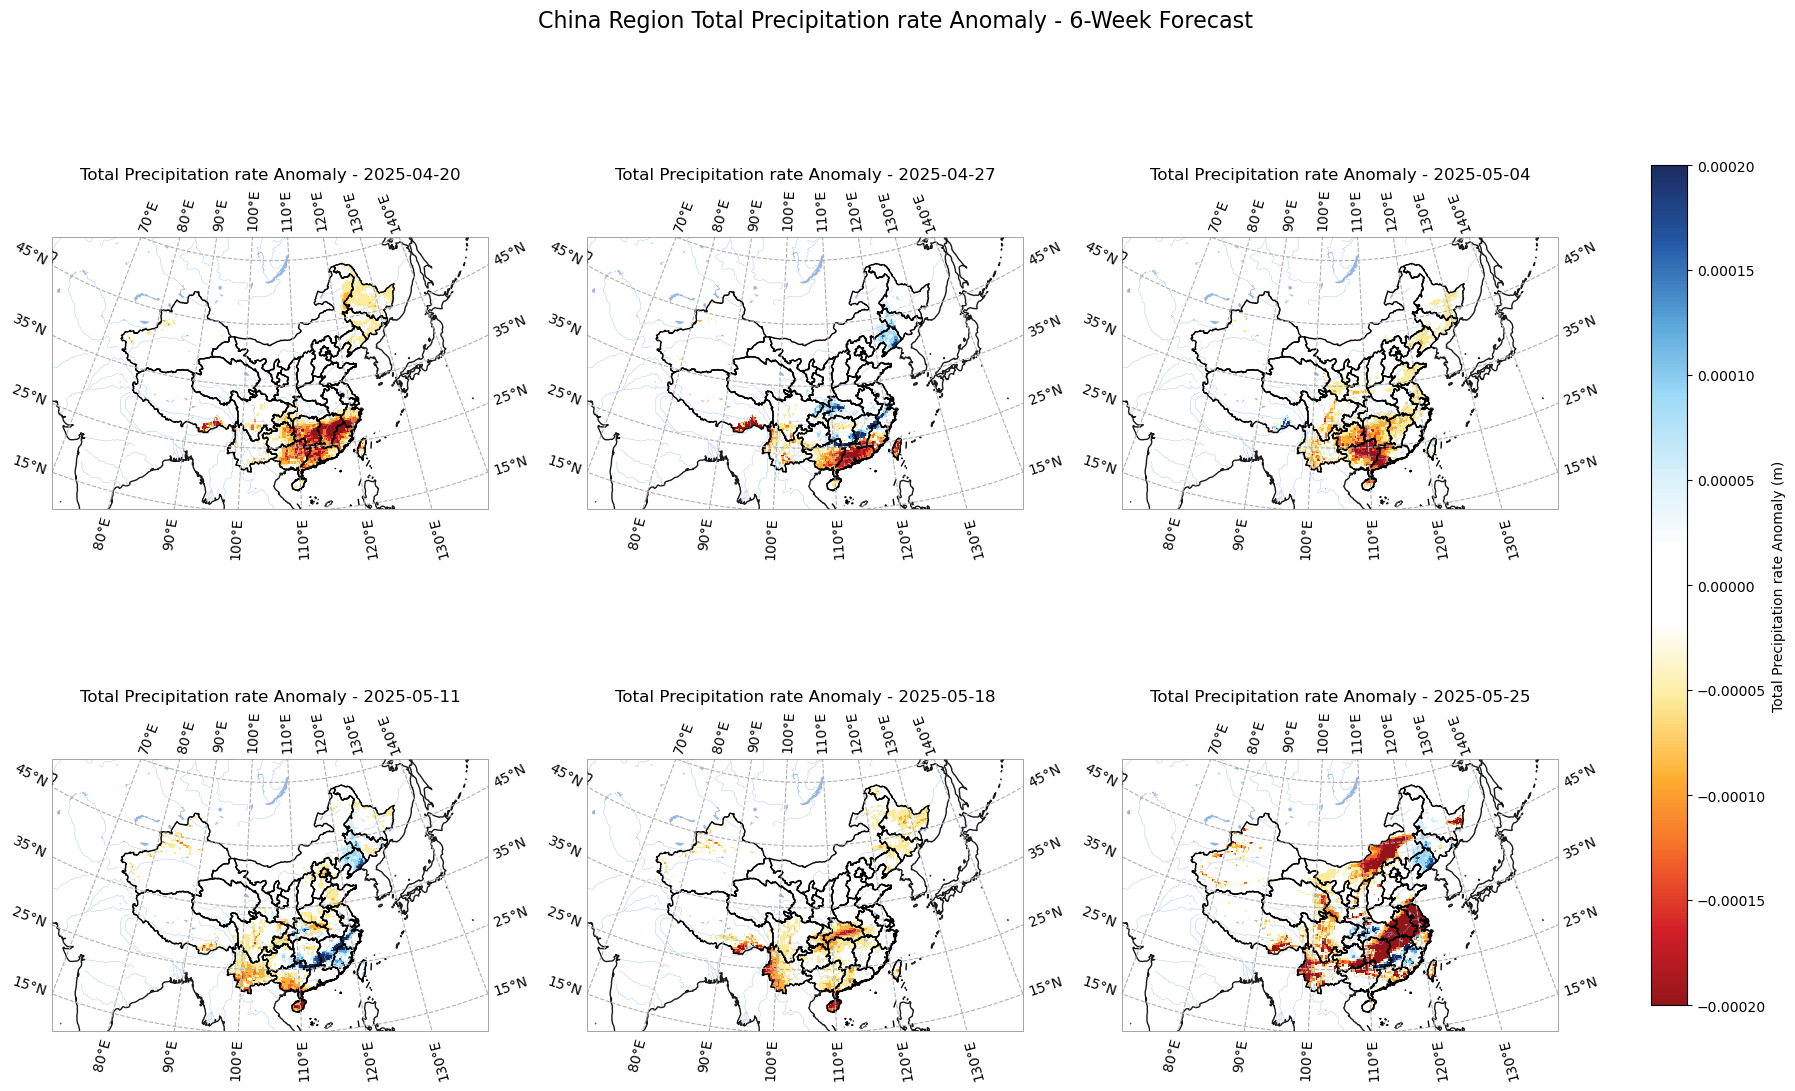

In [60]:
# 定义可选变量
variable_name = 'total_precipitation'  # 可以改为 'total_precipitation', 'wind_speed' 或其他变量

# 选择中国区域的数据
china_data = anomaly_ds[variable_name].sel(
    longitude=slice(70, 140),
    latitude=slice(55, 15)  # 注意纬度是从北到南排列的，所以高纬度在前
)

# 导入必要的库
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import salem
import cmaps
import cartopy.crs as ccrs
from utils import plot

# 读取中国边界shapefile
china_shp = gpd.read_file(r'D:\Onedrive\data\china.shp')

# 使用salem创建掩膜
# 将数据转换为salem.DataArray以便使用salem的功能
ds = salem.DataArrayAccessor(china_data.isel(time=0))
# 使用salem的roi方法创建掩膜
masked_da = ds.roi(shape=china_shp)

# 应用掩膜：只显示中国陆地上的数据
masked_data = masked_da.copy()

# 根据变量设置合适的色标和范围
if variable_name == 'wind_speed':
    data_cmap = cmaps.BlueWhiteOrangeRed
    vmin, vmax = -5, 5  # 风速距平范围
    unit_label = 'm/s'
    title_prefix = 'Wind Speed Anomaly'
elif variable_name == 'total_precipitation':
    data_cmap = cmaps.BlueWhiteOrangeRed_r  # 使用距平色卡
    vmin, vmax = -0.0002, 0.0002  # 降水距平范围
    unit_label = 'm'
    title_prefix = 'Total Precipitation rate Anomaly'
elif variable_name == '2m_temperature':
    data_cmap = cmaps.temp_diff_18lev  # 使用温度距平色卡
    vmin, vmax = -5, 5  # 温度距平范围，摄氏度
    unit_label = '°C'
    title_prefix = '2m Temperature Anomaly'
else:
    data_cmap = cmaps.BlueWhiteOrangeRed
    # 自动确定数据范围
    all_data = china_data.values
    vmin, vmax = np.nanpercentile(all_data, [5, 95])
    unit_label = ''
    title_prefix = f'{variable_name.replace("_", " ").title()} Anomaly'

# 创建图形和投影
fig = plt.figure(figsize=(18, 12))
proj = ccrs.LambertConformal(central_longitude=105, 
                            central_latitude=40,
                            standard_parallels=(25.0, 47.0))

# 创建2x3的子图布局
axes = []
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection=proj)
    axes.append(ax)

# 设置等值线级别
levels = np.linspace(vmin, vmax, 11)  # 创建10个等间隔的级别

# 创建一个标准化对象，确保色标和绘图使用相同的映射
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# 遍历所有时间点
for t in range(6):
    ax = axes[t]
    
    # 获取当前时间点的数据
    current_data = china_data.isel(time=t)
    # 将数据转换为salem.DataArray
    ds_t = salem.DataArrayAccessor(current_data)
    # 使用salem的roi方法创建掩膜
    masked_data_t = ds_t.roi(shape=china_shp)
    
    # 使用plot包绘制中国地区的数据分布，并传入norm参数确保颜色映射一致
    plot.one_map_china(
        masked_data_t, 
        ax, 
        cmap=data_cmap, 
        levels=levels,
        norm=norm,  # 添加标准化对象
        mask_ocean=False, 
        add_coastlines=True, 
        add_land=False, 
        add_river=True, 
        add_lake=True, 
        add_stock=False, 
        add_gridlines=True, 
        colorbar=False, 
        plotfunc="pcolormesh"
    )
    
    # 获取当前时间
    current_time = china_data.time.values[t]
    time_str = np.datetime_as_string(current_time, unit='D')
    
    # 设置标题
    ax.set_title(f'{title_prefix} - {time_str}')

# 添加共享的色标，使用相同的标准化对象
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=data_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(f'{title_prefix} ({unit_label})')

plt.suptitle(f'China Region {title_prefix} - 6-Week Forecast', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 调整布局以适应色标
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_42492\970034292.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 调整布局以适应色标


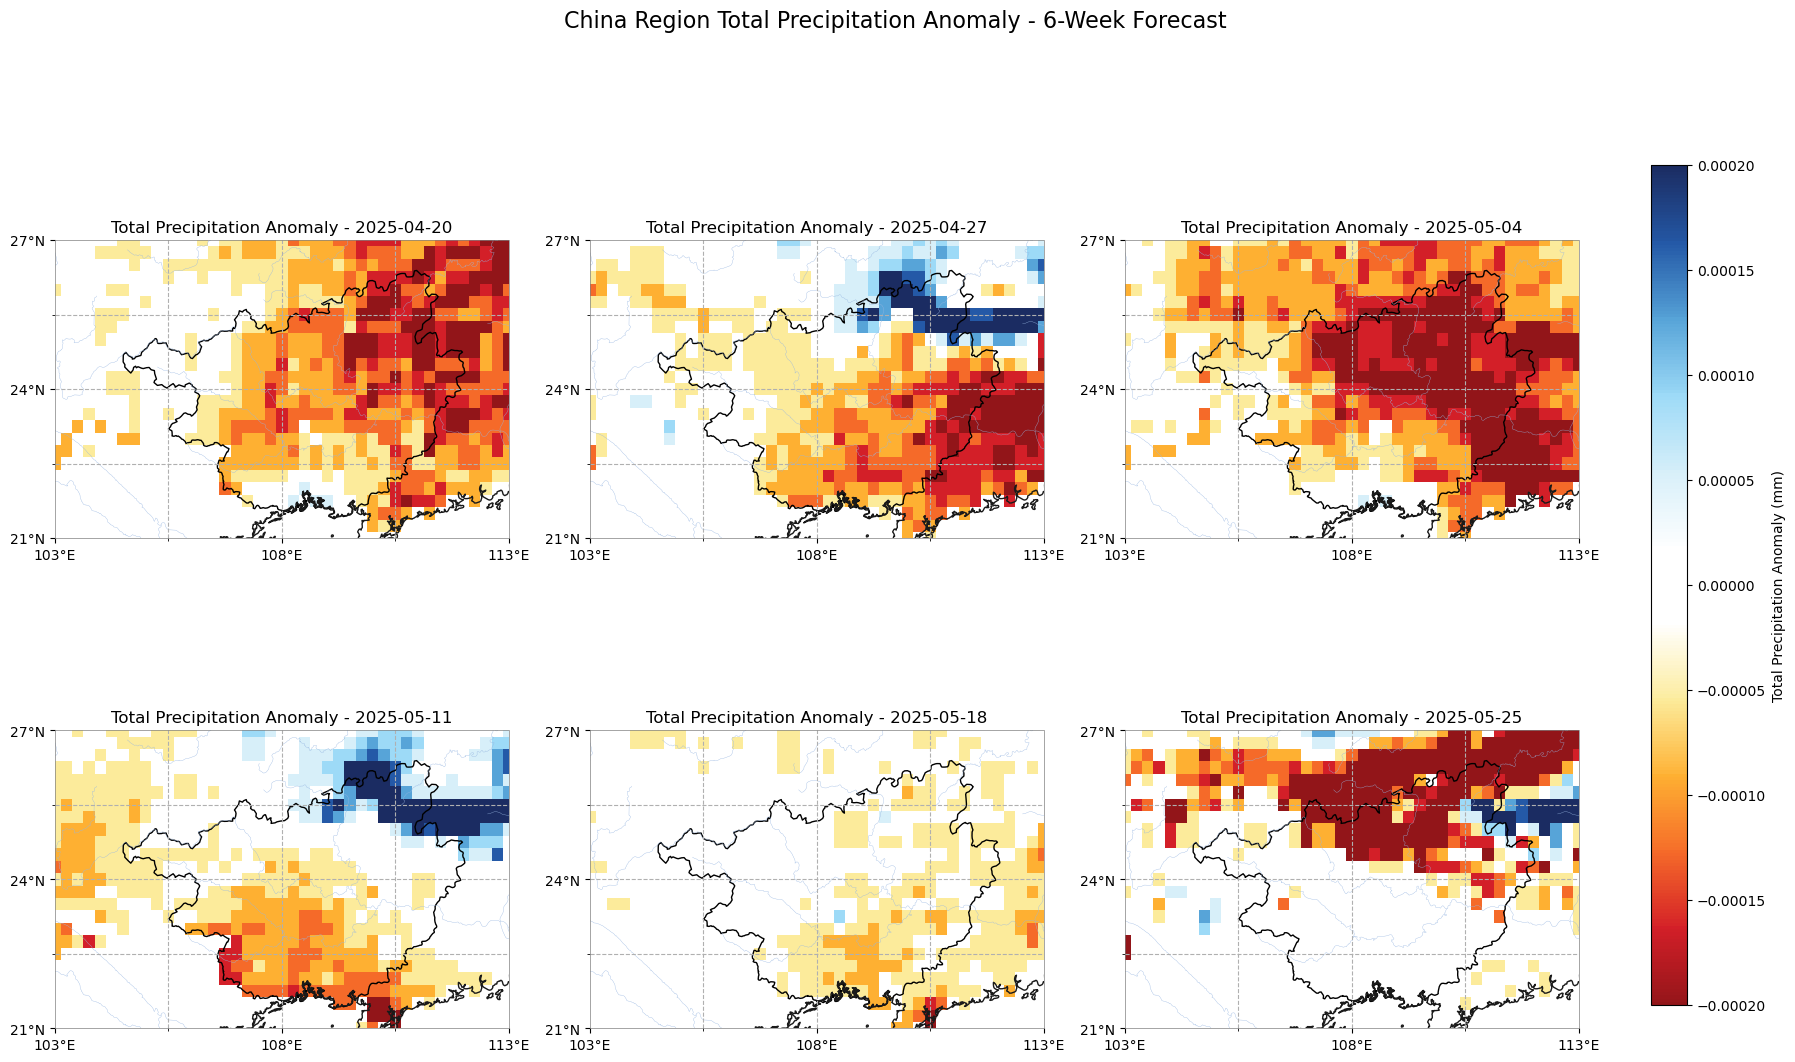

In [65]:
# 定义可选变量
variable_name = 'total_precipitation'  # 可以改为 'total_precipitation', 'wind_speed' 或其他变量

# 选择中国区域的数据
china_data = anomaly_ds[variable_name].sel(
    longitude=slice(103, 113),
    latitude=slice(27, 21)  # 注意纬度是从北到南排列的，所以高纬度在前
)

# 导入必要的库
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import salem
import cmaps
import cartopy.crs as ccrs
from utils import plot

# 读取中国边界shapefile
shp = gpd.read_file(r'D:\Onedrive\data\guangxi.shp')

# 使用salem创建掩膜
# 将数据转换为salem.DataArray以便使用salem的功能
ds = salem.DataArrayAccessor(china_data.isel(time=0))
# 使用salem的roi方法创建掩膜
masked_da = ds.roi(shape=shp)

# 应用掩膜：只显示中国陆地上的数据
masked_data = masked_da.copy()

# 根据变量设置合适的色标和范围
if variable_name == 'wind_speed':
    data_cmap = cmaps.BlueWhiteOrangeRed
    vmin, vmax = -5, 5  # 风速距平范围
    unit_label = 'm/s'
    title_prefix = 'Wind Speed Anomaly'
elif variable_name == 'total_precipitation':
    data_cmap = cmaps.BlueWhiteOrangeRed_r  # 使用距平色卡
    vmin, vmax = -0.0002, 0.0002  # 降水距平范围
    unit_label = 'mm'
    title_prefix = 'Total Precipitation Anomaly'
elif variable_name == '2m_temperature':
    data_cmap = cmaps.temp_diff_18lev  # 使用温度距平色卡
    vmin, vmax = -5, 5  # 温度距平范围，摄氏度
    unit_label = '°C'
    title_prefix = '2m Temperature Anomaly'
else:
    data_cmap = cmaps.BlueWhiteOrangeRed
    # 自动确定数据范围
    all_data = china_data.values
    vmin, vmax = np.nanpercentile(all_data, [5, 95])
    unit_label = ''
    title_prefix = f'{variable_name.replace("_", " ").title()} Anomaly'

# 创建图形和投影
fig = plt.figure(figsize=(18, 12))
proj = ccrs.PlateCarree()

# 创建2x3的子图布局
axes = []
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection=proj)
    axes.append(ax)

# 设置等值线级别
levels = np.linspace(vmin, vmax, 11)  # 创建10个等间隔的级别

# 创建一个标准化对象，确保色标和绘图使用相同的映射
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# 遍历所有时间点
for t in range(6):
    ax = axes[t]
    
    # 获取当前时间点的数据
    current_data = china_data.isel(time=t)
    # 将数据转换为salem.DataArray
    ds_t = salem.DataArrayAccessor(current_data)
    # 使用salem的roi方法创建掩膜
    masked_data_t = ds_t.roi(shape=china_shp)
    
    # 使用plot包绘制中国地区的数据分布，并传入norm参数确保颜色映射一致
    plot.one_map_region(
        masked_data_t, 
        ax, 
        cmap=data_cmap, 
        levels=levels,
        extents=[103, 113, 21, 27],
        interval=[5, 3],
        norm=norm,  # 添加标准化对象
        mask_ocean=False, 
        add_coastlines=True, 
        add_land=False, 
        add_river=True, 
        add_lake=True, 
        add_stock=False, 
        add_gridlines=True, 
        colorbar=False, 
        plotfunc="pcolormesh"
    )
    
    # 添加shp边界
    shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
    
    # 获取当前时间
    current_time = china_data.time.values[t]
    time_str = np.datetime_as_string(current_time, unit='D')
    
    # 设置标题
    ax.set_title(f'{title_prefix} - {time_str}')

# 添加共享的色标，使用相同的标准化对象
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=data_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(f'{title_prefix} ({unit_label})')

plt.suptitle(f'China Region {title_prefix} - 6-Week Forecast', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 调整布局以适应色标
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_42492\1529670557.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 调整布局以适应色标


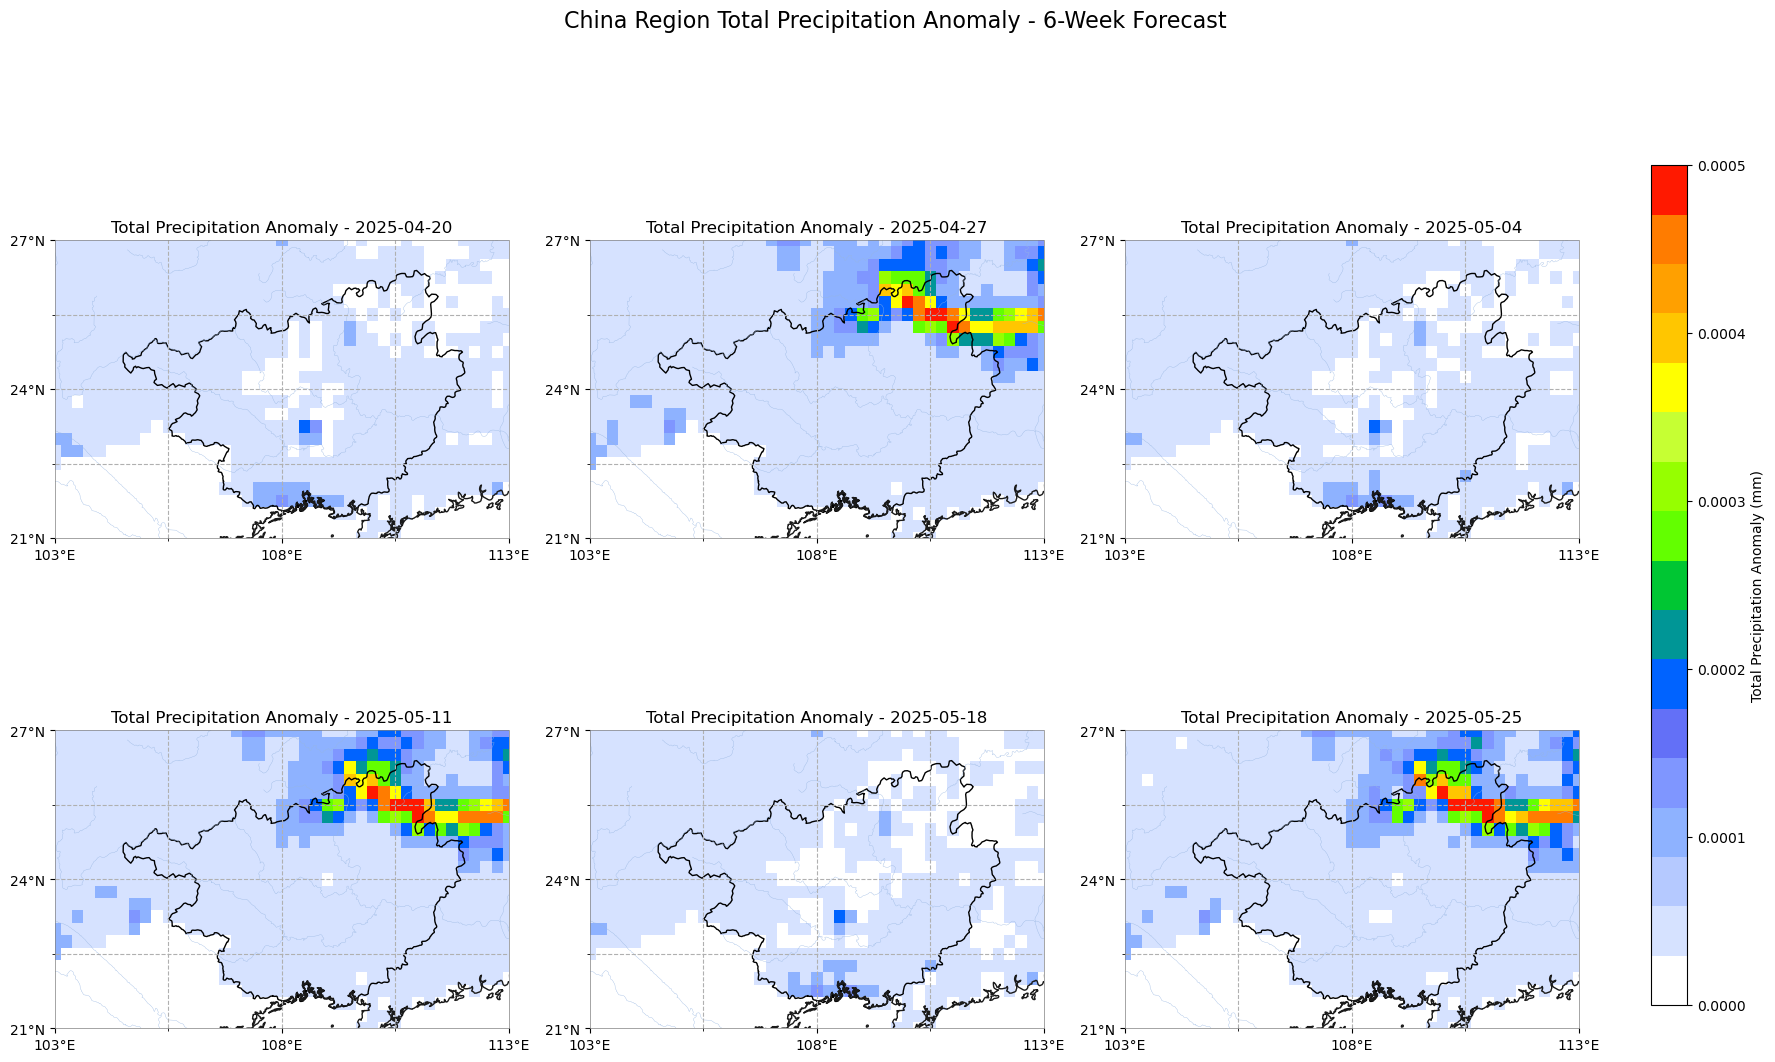

In [69]:
# 定义可选变量
variable_name = 'total_precipitation'  # 可以改为 'total_precipitation', 'wind_speed' 或其他变量

# 选择中国区域的数据
china_data = surface_ds[variable_name].sel(
    longitude=slice(103, 113),
    latitude=slice(27, 21)  # 注意纬度是从北到南排列的，所以高纬度在前
)

# 导入必要的库
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import salem
import cmaps
import cartopy.crs as ccrs
from utils import plot

# 读取中国边界shapefile
shp = gpd.read_file(r'D:\Onedrive\data\guangxi.shp')

# 使用salem创建掩膜
# 将数据转换为salem.DataArray以便使用salem的功能
ds = salem.DataArrayAccessor(china_data.isel(time=0))
# 使用salem的roi方法创建掩膜
masked_da = ds.roi(shape=shp)

# 应用掩膜：只显示中国陆地上的数据
masked_data = masked_da.copy()

# 根据变量设置合适的色标和范围
if variable_name == 'wind_speed':
    data_cmap = cmaps.BlueWhiteOrangeRed
    vmin, vmax = -5, 5  # 风速距平范围
    unit_label = 'm/s'
    title_prefix = 'Wind Speed Anomaly'
elif variable_name == 'total_precipitation':
    data_cmap = cmaps.precip3_16lev  # 使用距平色卡
    vmin, vmax = 0, 0.0005  # 降水距平范围
    unit_label = 'mm'
    title_prefix = 'Total Precipitation Anomaly'
elif variable_name == '2m_temperature':
    data_cmap = cmaps.temp_diff_18lev  # 使用温度距平色卡
    vmin, vmax = -5, 5  # 温度距平范围，摄氏度
    unit_label = '°C'
    title_prefix = '2m Temperature Anomaly'
else:
    data_cmap = cmaps.BlueWhiteOrangeRed
    # 自动确定数据范围
    all_data = china_data.values
    vmin, vmax = np.nanpercentile(all_data, [5, 95])
    unit_label = ''
    title_prefix = f'{variable_name.replace("_", " ").title()} Anomaly'

# 创建图形和投影
fig = plt.figure(figsize=(18, 12))
proj = ccrs.PlateCarree()

# 创建2x3的子图布局
axes = []
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection=proj)
    axes.append(ax)

# 设置等值线级别
levels = np.linspace(vmin, vmax, 11)  # 创建10个等间隔的级别

# 创建一个标准化对象，确保色标和绘图使用相同的映射
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# 遍历所有时间点
for t in range(6):
    ax = axes[t]

    if variable_name == 'total_precipitation':
        masked_data_t.values[masked_data_t.values < 0.0001] = np.nan
    
    # 获取当前时间点的数据
    current_data = china_data.isel(time=t)
    # 将数据转换为salem.DataArray
    ds_t = salem.DataArrayAccessor(current_data)
    # 使用salem的roi方法创建掩膜
    masked_data_t = ds_t.roi(shape=china_shp)
    
    # 使用plot包绘制中国地区的数据分布，并传入norm参数确保颜色映射一致
    plot.one_map_region(
        masked_data_t, 
        ax, 
        cmap=data_cmap, 
        levels=levels,
        extents=[103, 113, 21, 27],
        interval=[5, 3],
        norm=norm,  # 添加标准化对象
        mask_ocean=False, 
        add_coastlines=True, 
        add_land=False, 
        add_river=True, 
        add_lake=True, 
        add_stock=False, 
        add_gridlines=True, 
        colorbar=False, 
        plotfunc="pcolormesh"
    )
    
    # 添加shp边界
    shp.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
    
    # 获取当前时间
    current_time = china_data.time.values[t]
    time_str = np.datetime_as_string(current_time, unit='D')
    
    # 设置标题
    ax.set_title(f'{title_prefix} - {time_str}')

# 添加共享的色标，使用相同的标准化对象
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=data_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(f'{title_prefix} ({unit_label})')

plt.suptitle(f'China Region {title_prefix} - 6-Week Forecast', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 调整布局以适应色标
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_42492\3699865632.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 调整布局以适应色标


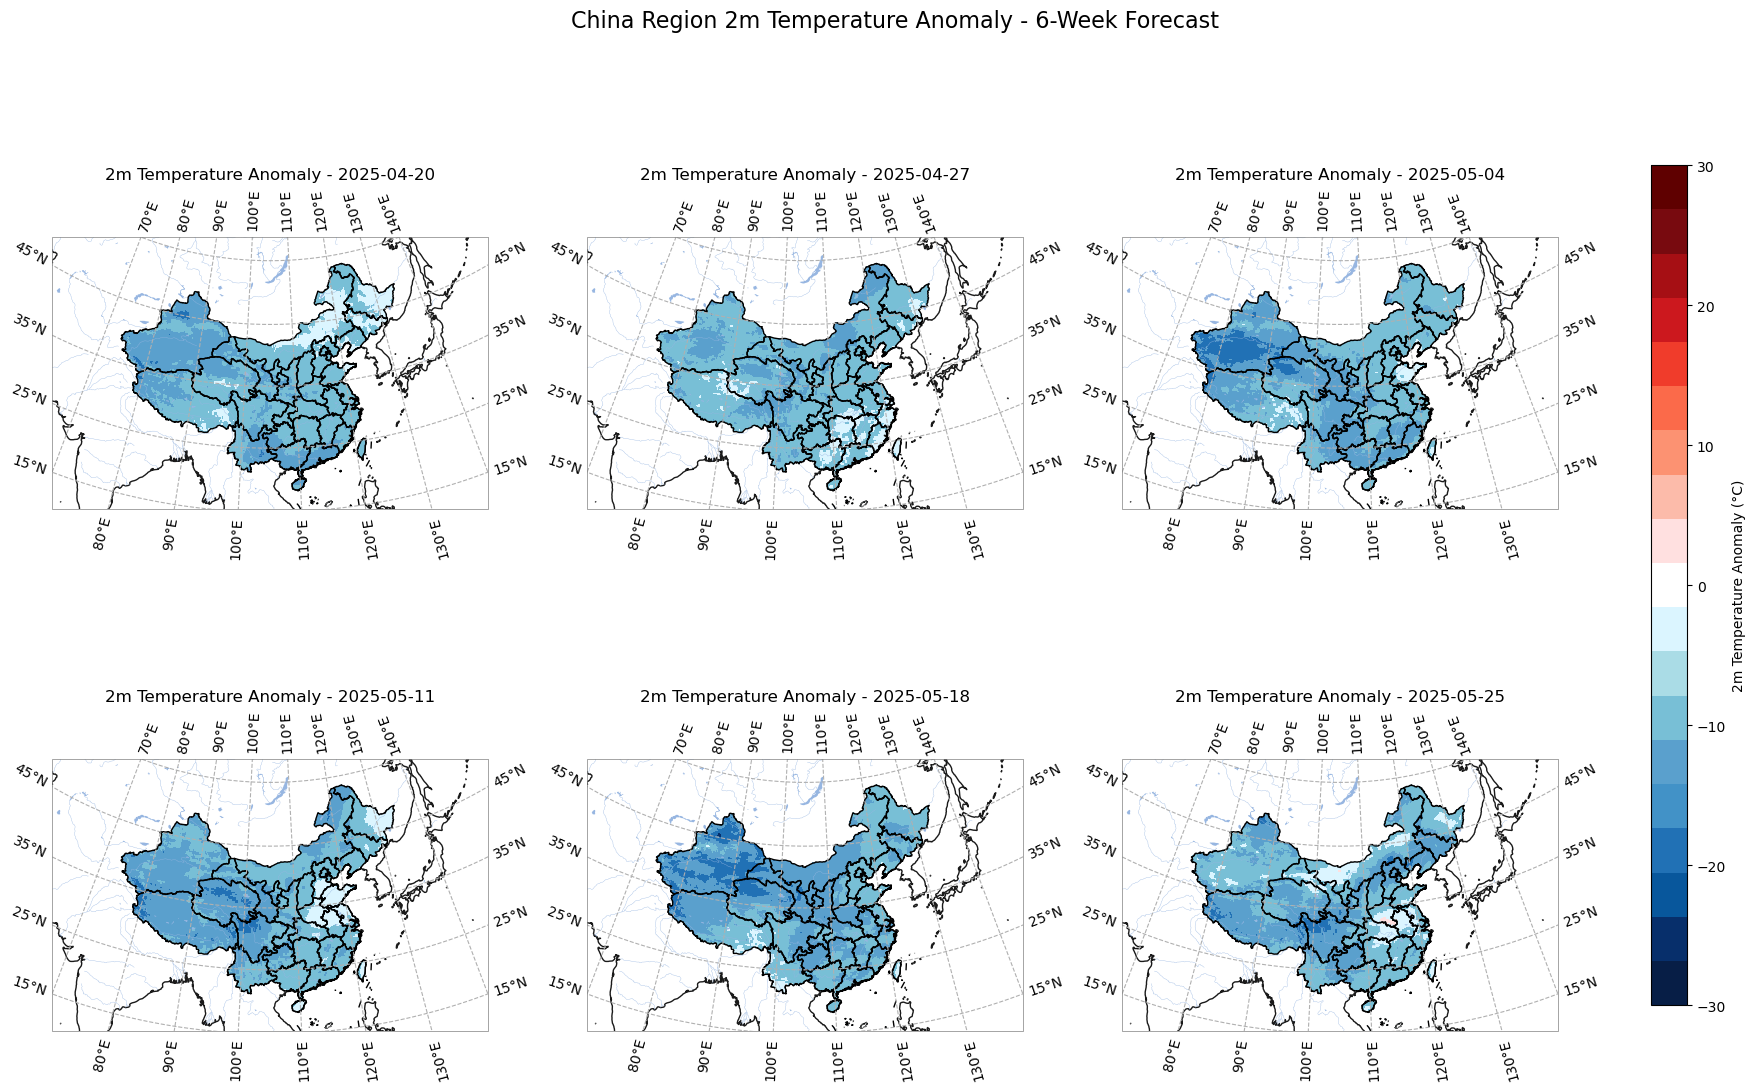

In [50]:
# 定义可选变量
variable_name = '2m_temperature'  # 可以改为 'total_precipitation', 'wind_speed' 或其他变量

# 选择中国区域的数据
china_data = anomaly_ds[variable_name].sel(
    longitude=slice(70, 140),
    latitude=slice(55, 15)  # 注意纬度是从北到南排列的，所以高纬度在前
)

# 导入必要的库
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import salem
import cmaps
import cartopy.crs as ccrs
from utils import plot

# 读取中国边界shapefile
china_shp = gpd.read_file(r'D:\Onedrive\data\china.shp')

# 使用salem创建掩膜
# 将数据转换为salem.DataArray以便使用salem的功能
ds = salem.DataArrayAccessor(china_data.isel(time=0))
# 使用salem的roi方法创建掩膜
masked_da = ds.roi(shape=china_shp)

# 应用掩膜：只显示中国陆地上的数据
masked_data = masked_da.copy()

# 根据变量设置合适的色标和范围
if variable_name == 'wind_speed':
    data_cmap = cmaps.BlueWhiteOrangeRed
    vmin, vmax = -5, 5  # 风速距平范围
    unit_label = 'm/s'
    title_prefix = 'Wind Speed Anomaly'
elif variable_name == 'total_precipitation':
    data_cmap = cmaps.BlueWhiteOrangeRed  # 使用距平色卡
    vmin, vmax = -0.0002, 0.0002  # 降水距平范围
    unit_label = 'mm'
    title_prefix = 'Total Precipitation Anomaly'
elif variable_name == '2m_temperature':
    data_cmap = cmaps.temp_diff_18lev  # 使用温度距平色卡
    vmin, vmax = -30, 30  # 温度距平范围，摄氏度
    unit_label = '°C'
    title_prefix = '2m Temperature Anomaly'
else:
    data_cmap = cmaps.BlueWhiteOrangeRed
    # 自动确定数据范围
    all_data = china_data.values
    vmin, vmax = np.nanpercentile(all_data, [5, 95])
    unit_label = ''
    title_prefix = f'{variable_name.replace("_", " ").title()} Anomaly'

# 创建图形和投影
fig = plt.figure(figsize=(18, 12))
proj = ccrs.LambertConformal(central_longitude=105, 
                            central_latitude=40,
                            standard_parallels=(25.0, 47.0))

# 创建2x3的子图布局
axes = []
for i in range(6):
    ax = fig.add_subplot(2, 3, i+1, projection=proj)
    axes.append(ax)

# 设置等值线级别
levels = np.linspace(vmin, vmax, 11)  # 创建10个等间隔的级别

# 创建一个标准化对象，确保色标和绘图使用相同的映射
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# 遍历所有时间点
for t in range(6):
    ax = axes[t]
    
    # 获取当前时间点的数据
    current_data = china_data.isel(time=t)
    # 将数据转换为salem.DataArray
    ds_t = salem.DataArrayAccessor(current_data)
    # 使用salem的roi方法创建掩膜
    masked_data_t = ds_t.roi(shape=china_shp)
    
    # 使用plot包绘制中国地区的数据分布，并传入norm参数确保颜色映射一致
    plot.one_map_china(
        masked_data_t, 
        ax, 
        cmap=data_cmap, 
        levels=levels,
        norm=norm,  # 添加标准化对象
        mask_ocean=False, 
        add_coastlines=True, 
        add_land=False, 
        add_river=True, 
        add_lake=True, 
        add_stock=False, 
        add_gridlines=True, 
        colorbar=False, 
        plotfunc="pcolormesh"
    )
    
    # 获取当前时间
    current_time = china_data.time.values[t]
    time_str = np.datetime_as_string(current_time, unit='D')
    
    # 设置标题
    ax.set_title(f'{title_prefix} - {time_str}')

# 添加共享的色标，使用相同的标准化对象
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=data_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(f'{title_prefix} ({unit_label})')

plt.suptitle(f'China Region {title_prefix} - 6-Week Forecast', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # 调整布局以适应色标
plt.show()

## 计算SPEI

In [14]:
import xarray as xr

# Open the dataset
ds = xr.open_dataset('D:/Onedrive/data/temp.nc', engine='netcdf4')
ds


<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 721)
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
    time     datetime64[ns] ...
Data variables:
    t2m      (lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-19 16:34:11 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [16]:
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta

def generate_weekly_time_coords(start_year=2000, num_years=24, weeks_per_year=52):
    """
    生成从指定年份开始，每年52周的每周起始日期。
    """
    all_start_dates = []
    for year_offset in range(num_years):
        current_year = start_year + year_offset
        # 每年的第一天
        year_start_date = datetime(current_year, 1, 1)
        for week_num in range(weeks_per_year):
            # 每周的开始日期是当年1月1日加上 7 * 周数 (从0开始)
            week_start_date = year_start_date + timedelta(days=week_num * 7)
            all_start_dates.append(week_start_date)
    return pd.to_datetime(all_start_dates)

def calculate_pet(ta_celsius, td_celsius):
    """
    计算潜在蒸散发 (PET)。
    PET = 4.5 * (1 + Ta/25)^2 * (1 - ea/es)
    ea = 0.618 * exp(17.27 * Td / (Td + 237.3))
    es = 0.618 * exp(17.27 * Ta / (Ta + 237.3))
    ta_celsius: 气温 (摄氏度)
    td_celsius: 露点温度 (摄氏度)
    """
    # 防止Ta或Td过低导致分母接近0，尽管在实际气象数据中不太可能出现极端负值
    # 但为避免潜在的 RuntimeWarning for invalid value in power or exp，这里不加额外检查
    # np.exp 对于非常大的负指数会趋近于0，对于非常大的正指数会溢出，但气象数据应在合理范围

    es = 0.618 * np.exp(17.27 * ta_celsius / (ta_celsius + 237.3))
    ea = 0.618 * np.exp(17.27 * td_celsius / (td_celsius + 237.3))

    # 确保 es 不为零以避免除零错误
    # 在实际气温下，es 总是正数，但为了代码的健壮性可以考虑处理 es 接近零的情况
    # 不过，对于典型的地球表面温度，es 不会为零或负。
    ratio_ea_es = np.full_like(ta_celsius, np.nan) # 初始化为 NaN
    # 只有当 es > 0 时才计算比率，以避免潜在的除零警告或错误
    # 实际上，对于真实的气象温度，es 总是正的。
    # 一个更安全的做法是处理 es 可能非常小的情况，但这通常在物理上不太可能。
    valid_es_mask = es > 1e-9 # 设定一个小的阈值
    ratio_ea_es[valid_es_mask] = ea[valid_es_mask] / es[valid_es_mask]
    
    # 确保 ea/es <= 1，因为 ea (实际水汽压) 通常不应超过 es (饱和水汽压)
    # 如果 ea > es，空气过饱和，可能会发生凝结，此时 PET 的物理意义可能不同
    # 为简化，这里我们clip一下，或者假设输入数据中ea <= es
    ratio_ea_es = np.clip(ratio_ea_es, None, 1.0)


    pet = 4.5 * np.power((1 + ta_celsius / 25.0), 2) * (1 - ratio_ea_es)
    
    # PET 不应为负值
    pet = np.maximum(pet, 0)
    return pet

def main():
    # --- 1. 加载数据 ---
    print("正在加载 .npy 文件...")
    try:
        # 请确保你的文件路径是正确的
        base_path = 'G:/ERA5/npy/' # 你可以修改这个基础路径
        crr = np.load(f'{base_path}crr.npy')    # 假设单位: m/hr
        d2m = np.load(f'{base_path}d2m.npy')    # 假设单位: K
        lsrr = np.load(f'{base_path}lsrr.npy')   # 假设单位: m/hr
        t2m = np.load(f'{base_path}t2m.npy')     # 假设单位: K
        print("数据加载完毕。")
    except FileNotFoundError as e:
        print(f"错误：找不到文件。请检查路径 '{base_path}' 是否正确以及文件是否存在。详细信息: {e}")
        return
    except Exception as e:
        print(f"加载数据时发生错误: {e}")
        return

    # 打印形状以确认
    print(f"crr shape: {crr.shape}") # 预期 (1248, 721, 1440)
    num_times, num_lats, num_lons = crr.shape

    if not (d2m.shape == lsrr.shape == t2m.shape == crr.shape):
        print("错误：输入的Numpy数组形状不一致。请确保所有文件具有相同的维度。")
        print(f"Shapes: crr={crr.shape}, d2m={d2m.shape}, lsrr={lsrr.shape}, t2m={t2m.shape}")
        return
    
    if num_lats != 721 or num_lons != 1440:
        print(f"警告：数据维度与预期的地理维度不符。预期 (..., 721, 1440)，实际为 (..., {num_lats}, {num_lons})")
        print("代码将继续执行，但请检查你的输入数据。")


    # --- 2. 准备坐标 ---
    print("正在准备坐标...")
    # 时间坐标
    # 2000年到2023年共24年
    time_coords = generate_weekly_time_coords(start_year=2000, num_years=24, weeks_per_year=52)
    if len(time_coords) != num_times:
        print(f"错误：生成的时间坐标数量 ({len(time_coords)}) 与数据中的时间步数 ({num_times}) 不匹配。")
        return

    # 纬度坐标
    lat_coords = np.linspace(90.0, -90.0, num_lats, dtype=np.float32)
    # 经度坐标
    lon_coords = np.linspace(0.0, 359.75, num_lons, dtype=np.float32)
    print("坐标准备完毕。")

    # --- 3. 单位转换和变量计算 ---
    print("正在进行单位转换和变量计算...")
    # 开尔文转换为摄氏度
    t2m_celsius = t2m - 273.15
    d2m_celsius = d2m - 273.15

    # 降水单位转换: m/hr -> mm/day
    # 1 m/hr = 1000 mm/hr = 1000 * 24 mm/day = 24000 mm/day
    m_hr_to_mm_day_factor = 24.0 * 1000.0
    lsrr_mm_day = lsrr * m_hr_to_mm_day_factor
    crr_mm_day = crr * m_hr_to_mm_day_factor # 假设 crr 单位也为 m/hr

    # 计算总降水 (tp)
    tp = lsrr_mm_day + crr_mm_day

    # 计算潜在蒸散发 (pet)
    # 注意：PET的计算需要气温和露点温度为摄氏度
    pet = calculate_pet(t2m_celsius, d2m_celsius)
    print("变量计算完毕。")

    # --- 4. 创建 xarray.Dataset ---
    print("正在创建 xarray.Dataset...")
    output_ds = xr.Dataset(
        data_vars={
            't2m': (('time', 'lat', 'lon'), t2m_celsius.astype(np.float32), 
                    {'units': 'Celsius', 
                     'long_name': '2 meter temperature'}),
            'tp': (('time', 'lat', 'lon'), tp.astype(np.float32), 
                   {'units': 'mm/day', 
                    'long_name': 'Total precipitation'}),
            'pet': (('time', 'lat', 'lon'), pet.astype(np.float32), 
                    {'units': 'mm/day (conceptual)', # PET单位与公式系数相关
                     'long_name': 'Potential Evapotranspiration (Penman simplified)'})
        },
        coords={
            'time': ('time', time_coords),
            'lat': ('lat', lat_coords, {'units': 'degrees_north'}),
            'lon': ('lon', lon_coords, {'units': 'degrees_east'})
        },
        attrs={
            'Conventions': 'CF-1.6', # 或更新的版本
            'history': f'{datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S GMT")} Python script by user.',
            'description': 'Weekly mean temperature, total precipitation, and potential evapotranspiration derived from ERA5-like data.',
            'source_files': 'crr.npy, d2m.npy, lsrr.npy, t2m.npy (assumed ERA5 reanalysis weekly averages or accumulations)'
        }
    )
    print("xarray.Dataset 创建完毕。")
    print("\n--- 生成的 Dataset 概览 ---")
    print(output_ds)
    print("---------------------------\n")

    # --- 5. 保存为 NetCDF 文件 ---
    output_filename = 'climate_variables_2000_2023_weekly.nc'
    print(f"正在将 Dataset 保存为 NetCDF 文件: {output_filename}...")
    try:
        output_ds.to_netcdf(output_filename, engine='netcdf4')
        print(f"文件 '{output_filename}' 已成功保存。")
    except Exception as e:
        print(f"保存 NetCDF 文件时发生错误: {e}")

if __name__ == '__main__':
    main()

正在加载 .npy 文件...
数据加载完毕。
crr shape: (1248, 721, 1440)
正在准备坐标...
坐标准备完毕。
正在进行单位转换和变量计算...
变量计算完毕。
正在创建 xarray.Dataset...
xarray.Dataset 创建完毕。

--- 生成的 Dataset 概览 ---
<xarray.Dataset>
Dimensions:  (time: 1248, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2023-12-24
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    t2m      (time, lat, lon) float32 -9.267 -9.267 -9.267 ... -28.41 -28.41
    tp       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pet      (time, lat, lon) float32 0.2463 0.2463 0.2463 ... 0.02224 0.02224
Attributes:
    Conventions:   CF-1.6
    history:       2025-05-08 06:55:04 GMT Python script by user.
    description:   Weekly mean temperature, total precipitation, and potentia...
    source_files:  crr.npy, d2m.npy, lsrr.npy, t2m.npy (assumed ERA5 reanalys...
---------------